In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# path to directory of the measurements
FILE_PATH = 'Measurements/'
# All used sensors: Both reinhardt stations and meteo huts Lab19 and Lab24

In [2]:
def set_time_index(df, columns, format = None):
    if format is None:
        df['Datetime'] = pd.to_datetime(df[columns])
    else:
        df['Datetime'] = pd.to_datetime(df[columns[0]] + ' ' + df[columns[1]], format=format)
    df.set_index('Datetime', inplace=True)
    df.drop(columns, axis=1, inplace=True)
    return df

In [3]:
def read_data():
    file_names = [FILE_PATH+'LAB19_20231122_1817.txt', FILE_PATH+'LAB20_20231122_1816.txt', FILE_PATH+'LAB22_20231122_1731.txt', FILE_PATH+'LAB24_20231122_1731.txt', FILE_PATH+'LAB26_20231122_1815.txt']
    meteo_huts_data = [pd.read_csv(file, delimiter=',', skiprows=1) for file in file_names]
    meteo_huts_data = [i.drop(i.columns[-1], axis=1) for i in meteo_huts_data]
    meteo_huts_data = [set_time_index(i, columns=['Date', 'Time'], format='%d/%m/%y %H:%M:%S') for i in meteo_huts_data]
    encoding = 'latin1'
    skiprows = [78, 81]
    columns_names = ['Year', 'month', 'day', 'hour', 'minute', 'second', 'measurement ID', 'measurement SubID', 'TaskSpecifier', 'Expected Hz Angle of Target', 'Expected V Angle of Target', 'Measured Hz Angle of Target', 'Measured V Angle of Target', 'Accuracy of Inclination Measurement', 'Slope Distance', 'Cross Onclination', 'Length Inclination of Total Station', 'Accuracy of Inclination Measurement', 'Time of Distance Measurement', 'Error Status (applying ATR correction)', 'Error Status (applying inclination correction)', 'Status of Inclination Switch', 'GeoCom Response Code', 'Time needed for executing the measurement', 'Station Number']
    file_names = [FILE_PATH+'COM28_data.txt', FILE_PATH+'COM29_data.txt']
    TS_data = [pd.read_csv(file, encoding=encoding, delimiter='/t', skiprows=skiprows[ind], header=None, engine='python') for ind, file in enumerate(file_names)]
    TS_data = [i[0].str.split(expand=True) for i in TS_data]
    TS_data[0].columns, TS_data[1].columns = columns_names, columns_names
    TS_data = [set_time_index(i, columns=['Year', 'month', 'day', 'hour', 'minute', 'second']) for i in TS_data]
    start_date_dft1 = '22.11.2023 16:28:30'
    skiprows = [22, 0]
    encoding = ['latin1', None]
    delimiter = ['/t', ',']
    engines = ['python', 'c']
    file_names = [FILE_PATH+'Reinhard_big_MWS95.txt', FILE_PATH+'Reinhard_small_DFT1MV.txt']
    reinhard_data = [pd.read_csv(file, encoding=encoding[ind], delimiter=delimiter[ind], skiprows=skiprows[ind], header=None, engine=engines[ind]) for ind, file in enumerate(file_names)]
    reinhard_data[1] = reinhard_data[1].drop(reinhard_data[1].columns[-1], axis=1)
    date_index = pd.date_range(start=start_date_dft1, periods=len(reinhard_data[1]), freq='2S')
    reinhard_data[1].index = date_index
    reinhard_data[1].index.name = 'Datetime'
    reinhard_data[1] = reinhard_data[1].drop([0, 1], axis=1)
    column_names = ['Temperature', 'Pressure', 'Humidity']
    reinhard_data[1].columns = column_names
    reinhard_data[0] = reinhard_data[0][0].str.split(expand=True)
    column_names = ['Year', 'month', 'day', 'hour', 'minute', 'second', 'Temperature', 'Global Radiation', 'barometric pressure', 'Winddirection', 'Humidity', 'Rain (accumulated amount since last reset)', 'Rain average', 'Windspeed', 'Windaverage', 'Windchill', 'dominant Winddirection since last reset', 'Wind Spike Speed', 'internal Sensor supply voltage']
    reinhard_data[0].columns = column_names
    reinhard_data[0] = set_time_index(reinhard_data[0], columns=['Year', 'month', 'day', 'hour', 'minute', 'second'])
    return TS_data, meteo_huts_data, reinhard_data

In [4]:
def apply_meteo_corrections(meteo, corrections, names):
    meteo['Temperature'] += corrections[names[0]].values[0]
    meteo['Pressure'] += corrections[names[1]].values[0]
    meteo['Humidity'] += corrections[names[2]].values[0]
    return meteo

In [5]:
def plot_meteo(df, name):
    fig, axs = plt.subplots(3, 1, figsize=(14, 10))  # 1 row, 3 columns
    if name == 'mws95' or name == 'dft1':
        name = name.upper()
    
    axs[0].plot(df['Temperature'])
    axs[0].set_title('Temperature')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Temperature [°C]')

    axs[1].plot(df['Pressure'])
    axs[1].set_title('Pressure')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Pressure [mbar]')

    axs[2].plot(df['Humidity'])
    axs[2].set_title('Humidity')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Humidity [%]')

    plt.suptitle(f'Meteorological Data of Sensor: {name}', fontsize=15)
    plt.tight_layout()
    plt.show()

In [6]:
def get_distance_corrections(meteo, name, plot):
    distance_corrections = pd.DataFrame()
    alpha = 1/273.15
    x = (7.5 * meteo['Temperature'] / (237.3 + meteo['Temperature'])) + 0.7857
    distance_corrections['Correction'] = 286.338 - (0.29535 * meteo['Pressure'] / (1 + alpha * meteo['Temperature']) - 4.126e-4 * meteo['Humidity']/(1 + alpha * meteo['Temperature']) * 10**x)
    if plot:
        plot_meteo(meteo, name)
    return distance_corrections

In [7]:
def plot_dist_corrections(df, TS_name, sensor_name):
    if sensor_name == 'mws95' or sensor_name == 'dft1':
        sensor_name = sensor_name.upper()
    df['Mean Correction'].plot(figsize=(10, 5))
    plt.title(f'Distance Corrections of Total Station: {TS_name}, using Meteorological Data from Sensor: {sensor_name}', fontsize=13)
    plt.xlabel('Time')
    plt.ylabel('Distance Corrections [ppm]')
    
    plt.tight_layout()
    plt.show()

In [8]:
def apply_distance_corrections(distance_corrections, TS_data, TS_name, sensor_name, plot):
    mean_values = []
    closest_index = (TS_data.index.searchsorted(distance_corrections.index[0]) - 1).clip(0, len(TS_data) - 1)
    closest_index_end = (TS_data.index.searchsorted(distance_corrections.index[-1])).clip(0, len(TS_data) - 1)
    TS_data = TS_data.iloc[closest_index:closest_index_end]
    for i in range(len(TS_data)-1):
        start_time = TS_data.index[i]
        end_time = TS_data.index[i + 1]
        values_within_interval = distance_corrections[(distance_corrections.index >= start_time) & (distance_corrections.index < end_time)]['Correction']
        mean_values.append(values_within_interval.mean())
    mean_values.append(None)
    TS_data['Mean Correction'] = mean_values
    if plot:
        plot_dist_corrections(TS_data, TS_name, sensor_name)
    TS_data['Corrected Slope Distance'] = TS_data['Slope Distance'].astype(np.float32) * (1 + TS_data['Mean Correction'] / 1e6)
    return TS_data['Corrected Slope Distance']

In [9]:
def select_meteo_data(meteo, names, ind):
    data = pd.DataFrame()
    for index, i in enumerate(['Temperature', 'Pressure', 'Humidity']):
        data[i] = meteo[names[index]]
    if ind==1:
        data = data.applymap(lambda x: float(''.join(filter(lambda c: c.isdigit() or c == '.', str(x)))) if pd.notna(x) else None)
    if ind==2 or ind==3:
        data['Pressure'] = data['Pressure']/100
    return data

In [10]:
def elim_outliers(df):
    thersholds = [2,1,10]
    df_no_outliers = pd.DataFrame()
    for ind, col in enumerate(df.columns):
        deltas = df[col].diff().abs()
        rapid_change_indices = deltas > thersholds[ind]
        df_no_outliers[col] = df[col][~rapid_change_indices]
    return df_no_outliers

In [11]:
def prepare_meteo_data(reinhard, meteo_huts):
    used_meteo = []
    names = [['Temperature', 'barometric pressure', 'Humidity'], ['Temperature', 'Pressure', 'Humidity'], ['TMP116 T', 'BME280 P', 'SHT31 H'], ['TMP116 T', 'BME280 P', 'SHT31 H']]
    sensors = ['mws95', 'dft1', 'Lab19', 'Lab24']
    for ind, i in enumerate([reinhard[0], reinhard[1], meteo_huts[0], meteo_huts[3]]):
        used_meteo.append(select_meteo_data(i, names[ind], ind))
        used_meteo[ind] = elim_outliers(used_meteo[ind].astype(np.float64))
    names[0][1] = 'Pressure'
    for i in range(len(names)):
        for j in range(len(names[i])):
            names[i][j] = f"{names[i][j]}_{sensors[i]}"
    corrections = pd.read_csv('Data/Corrected_data/all_vertical_offsets.csv')
    for i in range(len(used_meteo)):
        used_meteo[i] = apply_meteo_corrections(used_meteo[i], corrections, names[i])
    return used_meteo, sensors

In [12]:
def apply_corrections(TS, meteo, sensors, save=False, plot=True):
    TS_names = ['COM28', 'COM29']
    distance_corrections = []
    for ind, met in enumerate(meteo):
        distance_corrections.append(get_distance_corrections(met, sensors[ind], plot))
    slope_distances_TS1 = pd.DataFrame()
    slope_distances_TS2 = pd.DataFrame()
    for index, corr in enumerate(distance_corrections):
        slope_distances_TS1[f'{TS_names[0]}_{sensors[index]}'] = apply_distance_corrections(corr, TS[0], TS_names[0], sensors[index], plot)
    for index, corr in enumerate(distance_corrections):
        slope_distances_TS2[f'{TS_names[1]}_{sensors[index]}'] = apply_distance_corrections(corr, TS[1], TS_names[1], sensors[index], plot)
    if save:
        slope_distances_TS1.to_csv(f'Data/Corrected_data/corrected_distances_TS1.csv')
        slope_distances_TS2.to_csv(f'Data/Corrected_data/corrected_distances_TS2.csv')
    return [slope_distances_TS1, slope_distances_TS2]

In [13]:
def elim_outliers_measurements(df, column):
    threshold = 2
    data_column = df[column].values
    median_value = np.nanmedian(data_column)
    lower_bound = median_value - threshold
    upper_bound = median_value + threshold
    outliers = (data_column < lower_bound) | (data_column > upper_bound)
    df[column][outliers] = None
    return df

In [14]:
def prepare_elim_outliers_measurements(df, column):
    df['Group'] = np.arange(len(df)) % 5
    distances = []
    for i in range(5):
        distances.append(df[df['Group'] == i])
        distances[i] = elim_outliers_measurements(distances[i].astype(np.float32), column)
    df[column] = pd.concat([df_col[column] for df_col in distances], axis=0)
    df = df.drop(['Group'], axis=1)
    return df

In [15]:
def plot_dist_std(df, column):
    df['Group'] = np.arange(len(df)) % 5
    std_per_point = df.groupby('Group')[column].std()
    fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)
    if column.split("_")[0] == 'COM28':
        points=[1014, 1012, 1013, 1060, 1020]
    else:
        points=[1060, 1020, 1014, 1012, 1013]
    for i, ax in enumerate(axes, start=1):
        distances = df[df['Group'] == i - 1]
        ax.plot_date(distances.index, distances[column], '-')
        ax.set_title(f'Distances of Point: {points[i-1]}')
        ax.set_ylabel('Distance [m]')
        if i==5:
            ax.set_xlabel('Time')
        
        std_value = std_per_point[i - 1]
        ax.text(0.01, 0.9, f'Std: {std_value:.6f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    if column.split("_")[1] == 'mws95' or column.split("_")[1] == 'dft1':
        name = column.split("_")[1].upper()
    else:
        name = column.split("_")[1]
    plt.suptitle(f'Distance of Each Point Measured by Total Station: {column.split("_")[0]}, using Meteorological Data from Sensor: {name}', fontsize=15)
    plt.tight_layout()
    plt.show()

In [16]:
def process(slope_distances, plot=False):
    all_cols = [['COM28_mws95', 'COM28_dft1', 'COM28_Lab19', 'COM28_Lab24'], ['COM29_mws95', 'COM29_dft1', 'COM29_Lab19', 'COM29_Lab24']]
    for col in all_cols[0]:
        slope_distances[0] = prepare_elim_outliers_measurements(slope_distances[0], col)
        if plot:
            plot_dist_std(slope_distances[0], col)
    for col in all_cols[1]:
        slope_distances[1] = prepare_elim_outliers_measurements(slope_distances[1], col)
        if plot:
            plot_dist_std(slope_distances[1], col)
    return slope_distances

In [17]:
def plot_dist_comparison(df_org, df_corr, column, column_org):
    common_indices = df_org.index.intersection(df_corr.index)
    df_org = df_org.loc[common_indices]
    assert len(df_org)==len(df_corr)
    missing_indices_df_corr = df_corr[df_corr[column].isna()].index
    df_org.loc[missing_indices_df_corr, column_org] = None
    assert (df_corr[df_corr[column].isna()].index == df_org[df_org[column_org].isna()].index).all()
    df_org['Group'] = np.arange(len(df_org)) % 5
    std_per_point_org = df_org.groupby('Group')[column_org].std()
    df_corr['Group'] = np.arange(len(df_corr)) % 5
    std_per_point_corr = df_corr.groupby('Group')[column].std()
    fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)
    if column.split("_")[0] == 'COM28':
        points=[1014, 1012, 1013, 1060, 1020]
    else:
        points=[1060, 1020, 1014, 1012, 1013]
    for i, ax in enumerate(axes, start=1):
        distances = df_org[df_org['Group'] == i - 1]
        ax.plot_date(distances.index, distances[column_org], '-', alpha=0.7)
        distances = df_corr[df_corr['Group'] == i - 1]
        ax.plot_date(distances.index, distances[column], '-', color='r', alpha=0.7)
        ax.set_title(f'Distances of Point: {points[i-1]}')
        ax.set_ylabel('Distance [m]')
        if i==5:
            ax.set_xlabel('Time')
        if i==1:
            ax.legend(['Raw', 'Corrected'])
        
        std_value = std_per_point_org[i - 1]
        ax.text(0.01, 0.9, f'Std: {std_value:.6f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
        std_value = std_per_point_corr[i - 1]
        ax.text(0.01, 0.06, f'Std: {std_value:.6f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8), color='r')
    if column.split("_")[1] == 'mws95' or column.split("_")[1] == 'dft1':
        name = column.split("_")[1].upper()
    else:
        name = column.split("_")[1]
    plt.suptitle(f'Distance of Each Point Measured by Total Station: {column.split("_")[0]}, using Meteorological Data from Sensor: {name}', fontsize=15)
    plt.tight_layout()
    plt.show()

In [18]:
def process_TS(df, column):
    TS_distance = []
    TS_distance.append(prepare_elim_outliers_measurements(df[0], column))
    TS_distance.append(prepare_elim_outliers_measurements(df[1], column))
    return TS_distance

In [19]:
def prepare_plot(original_slope_distances, slope_distances):
    all_cols = [['COM28_mws95', 'COM28_dft1', 'COM28_Lab19', 'COM28_Lab24'], ['COM29_mws95', 'COM29_dft1', 'COM29_Lab19', 'COM29_Lab24']]
    for col in all_cols[0]:
        plot_dist_comparison(original_slope_distances[0], slope_distances[0], col, 'Slope Distance')
    for col in all_cols[1]:
        plot_dist_comparison(original_slope_distances[1], slope_distances[1], col, 'Slope Distance')

In [20]:
def main():
    TS, meteo_huts, reinhard = read_data()
    meteo, sensors = prepare_meteo_data(reinhard, meteo_huts)
    slope_distances = apply_corrections(TS, meteo, sensors, save=False, plot=True)
    slope_distances = process(slope_distances, plot=True)
    TS_distances = process_TS(TS, 'Slope Distance')
    prepare_plot(TS_distances, slope_distances)

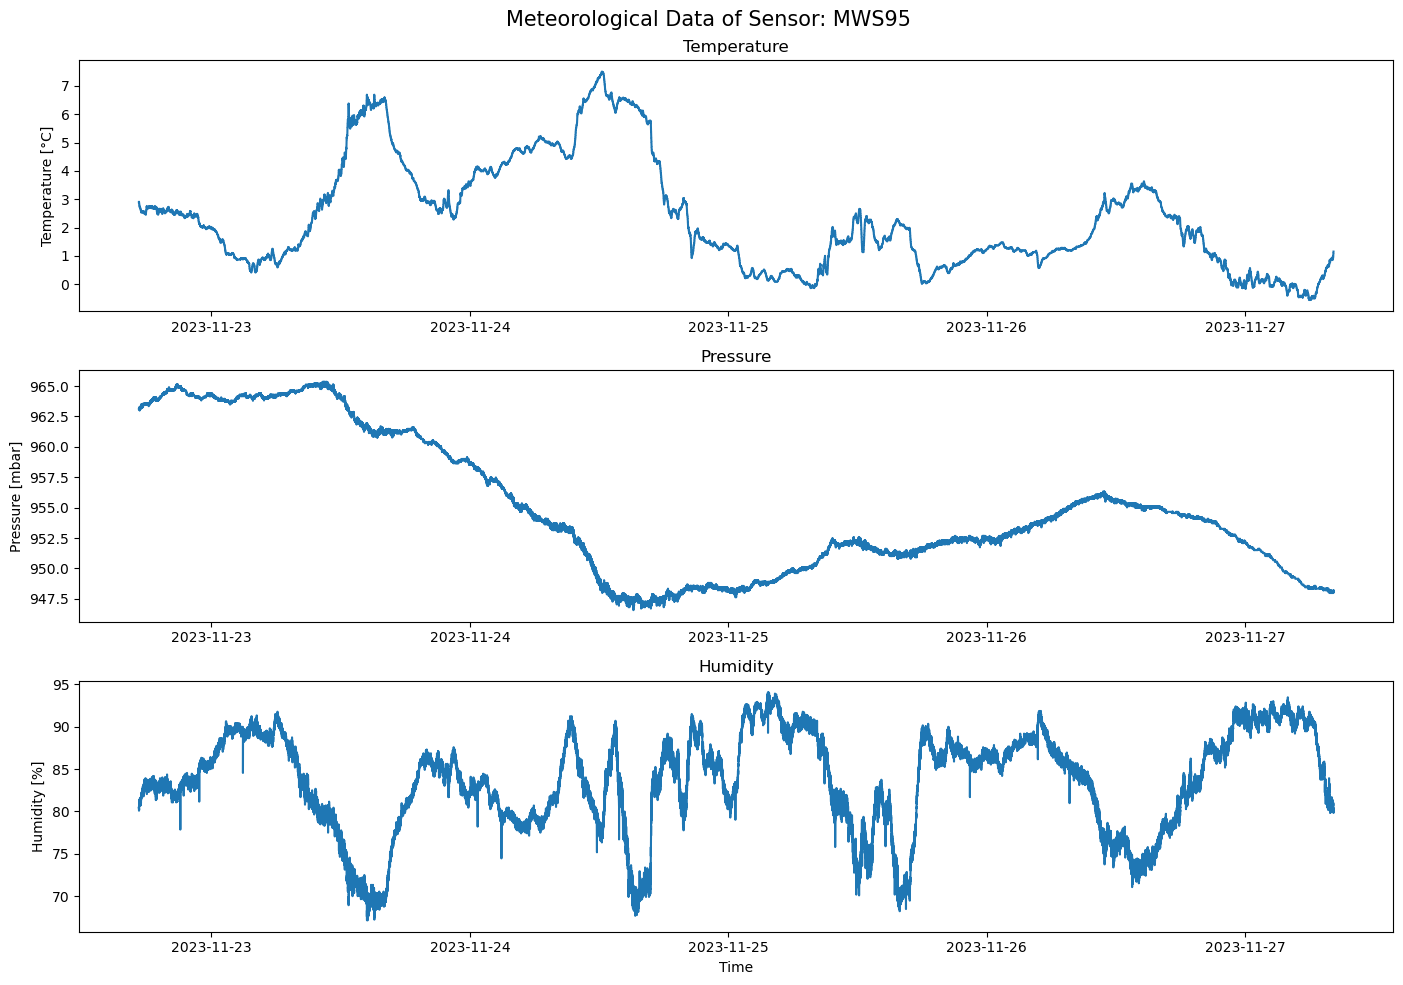

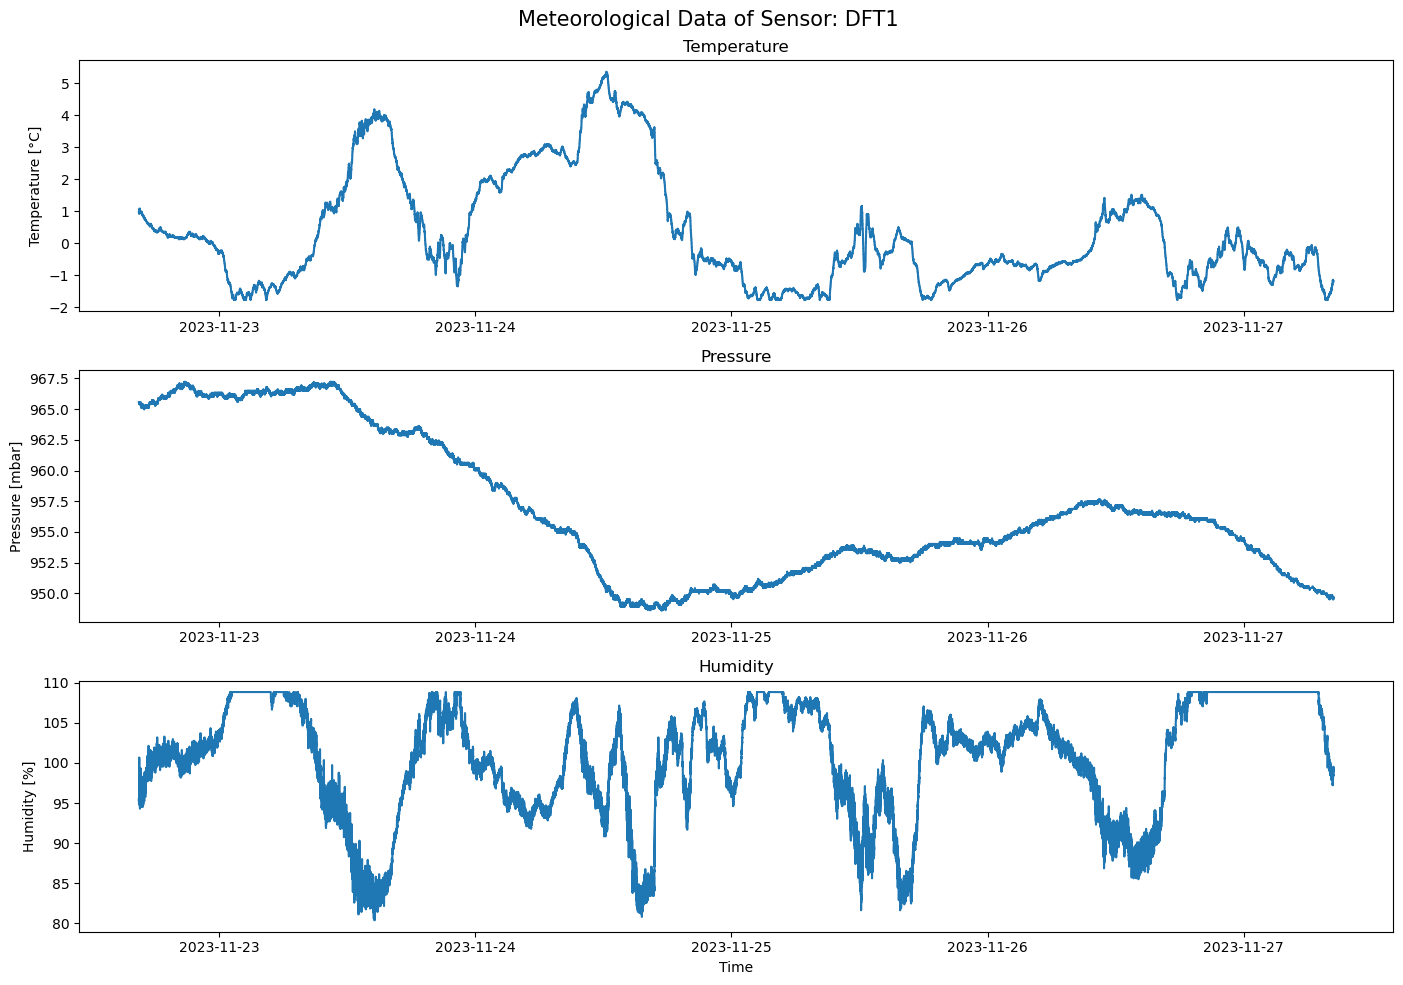

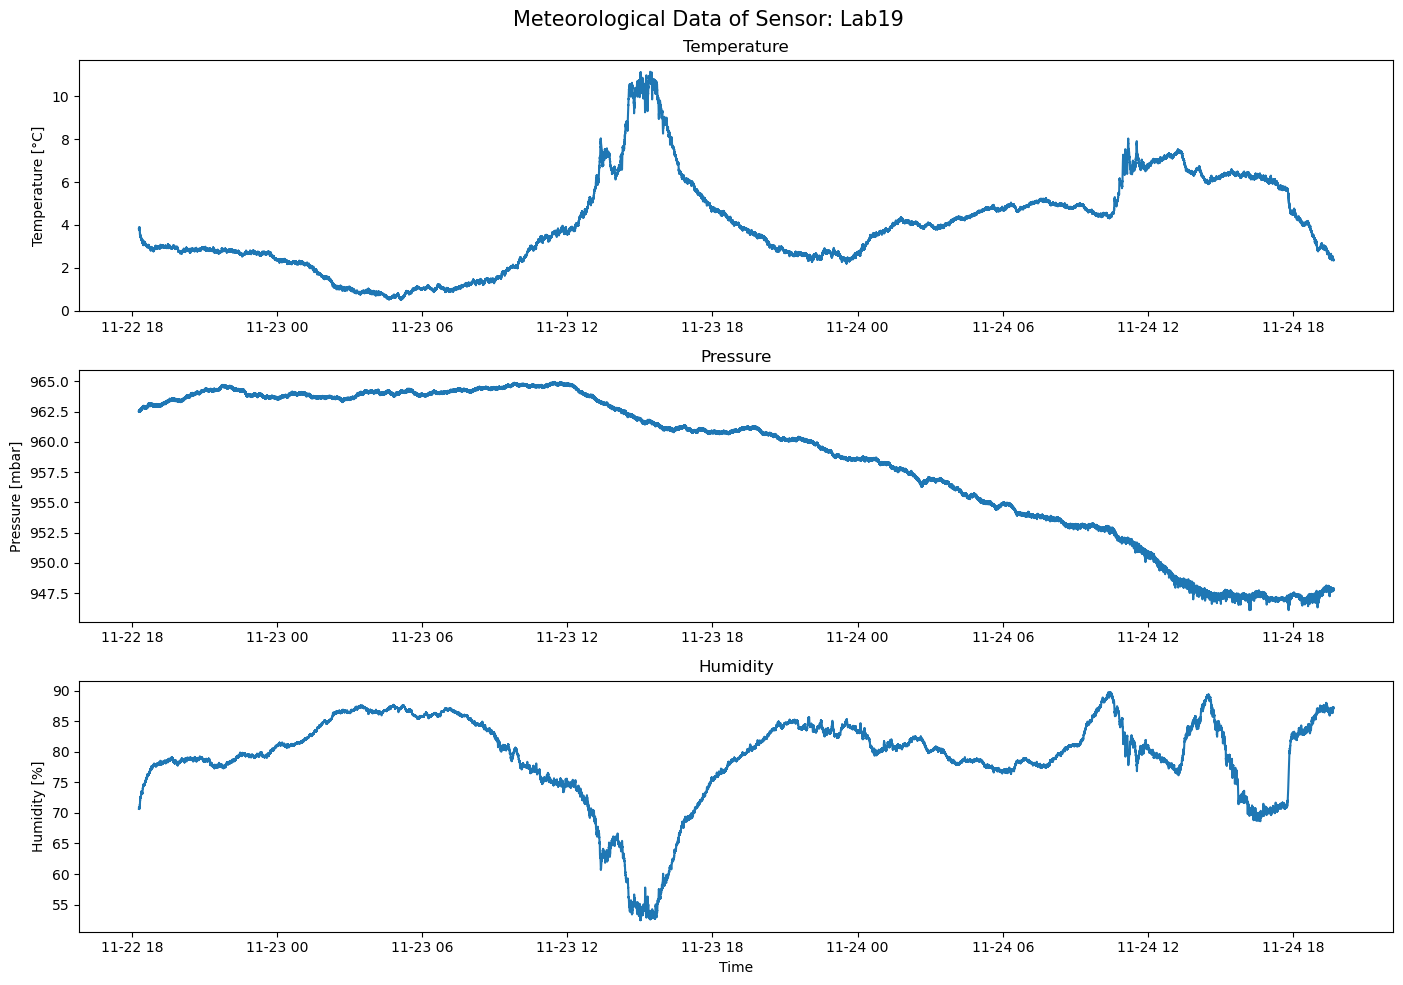

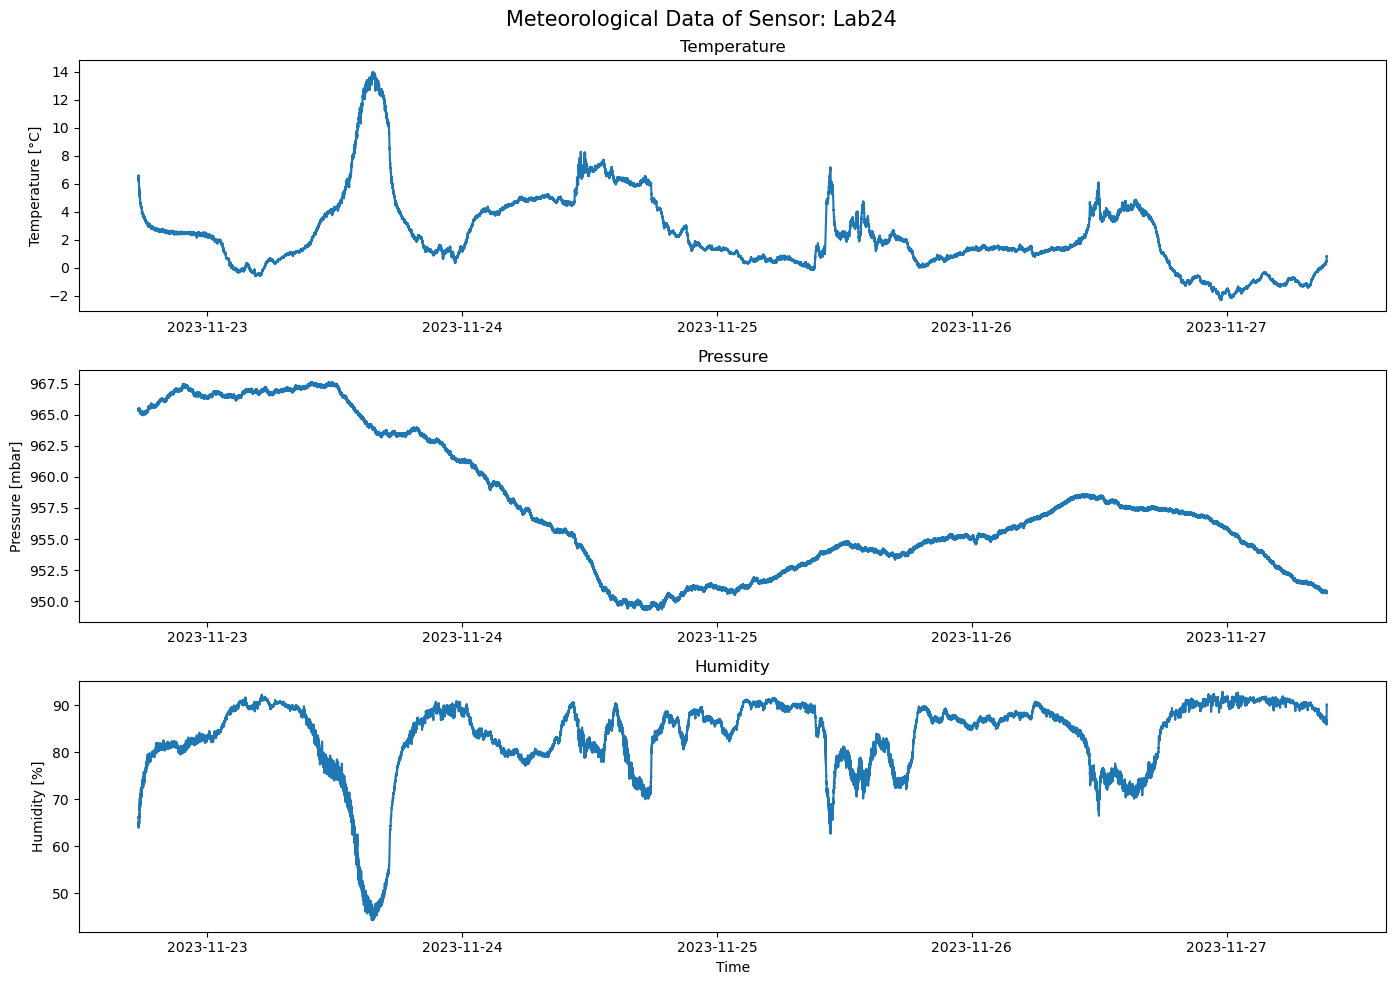

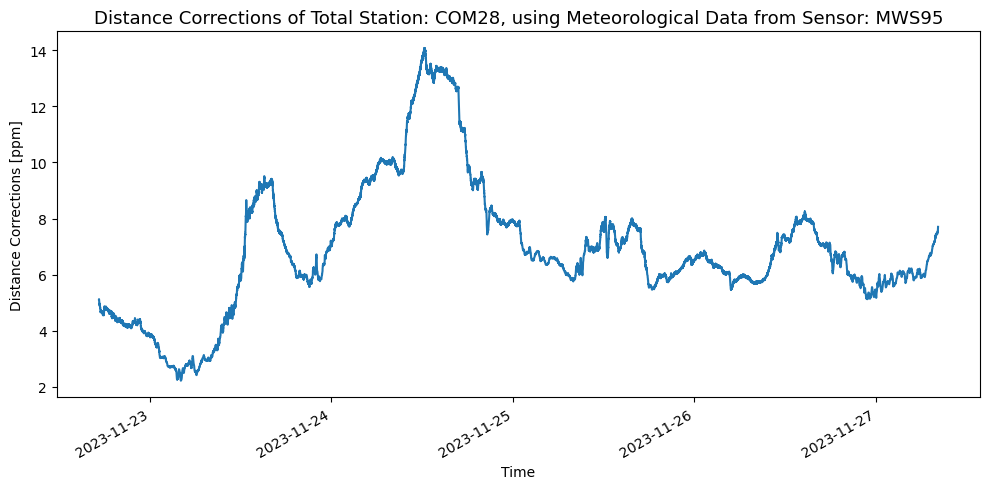

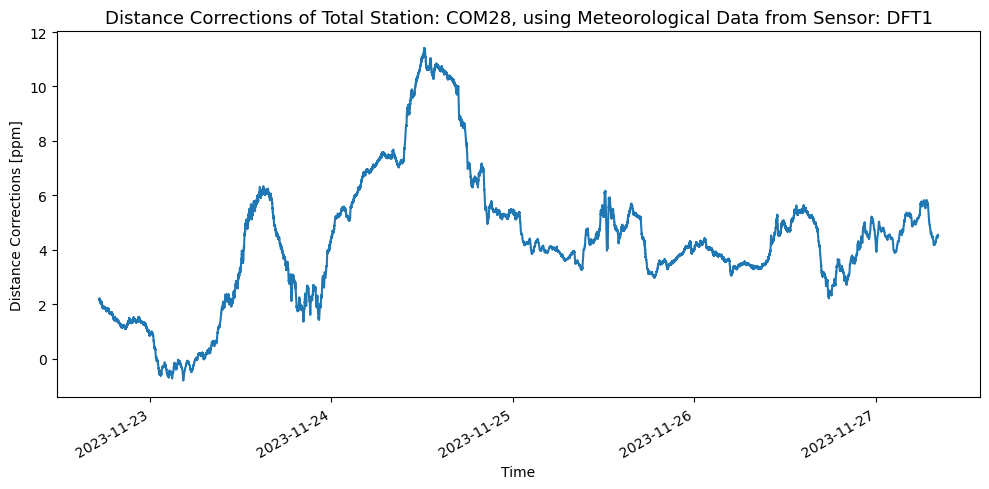

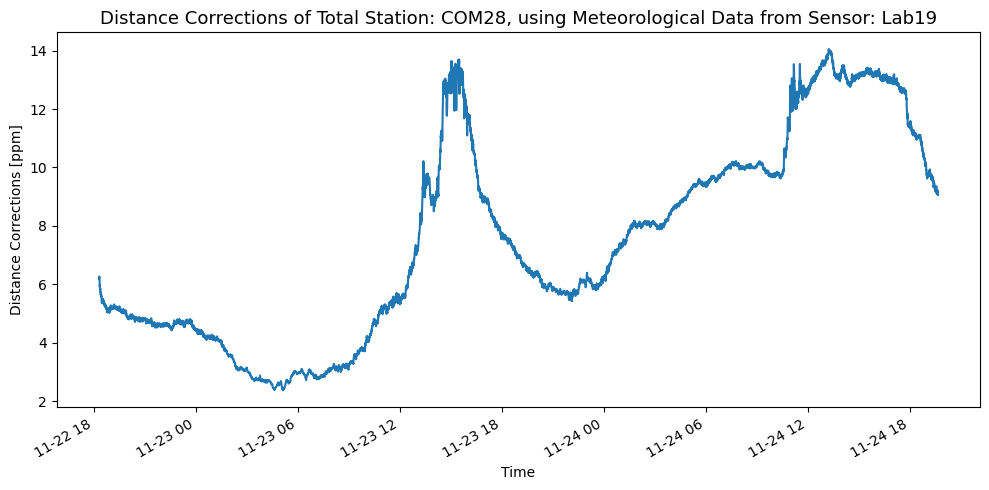

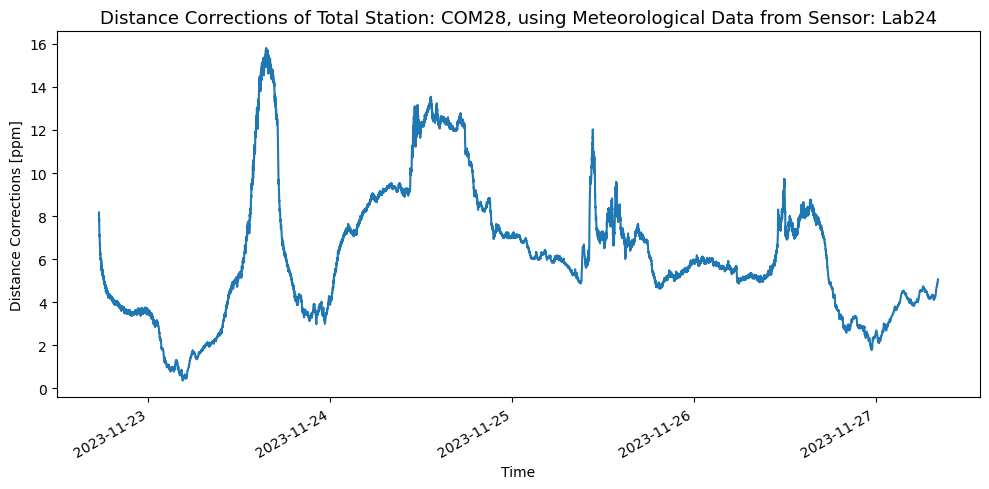

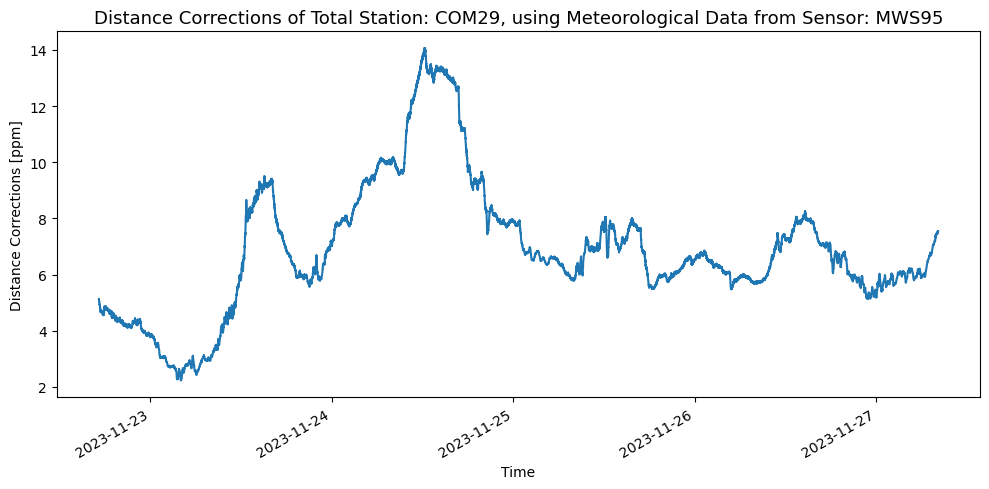

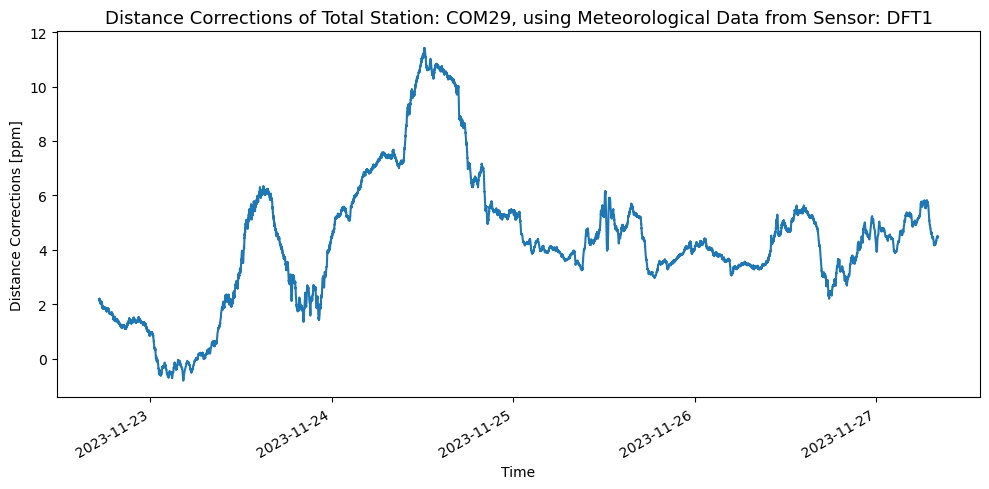

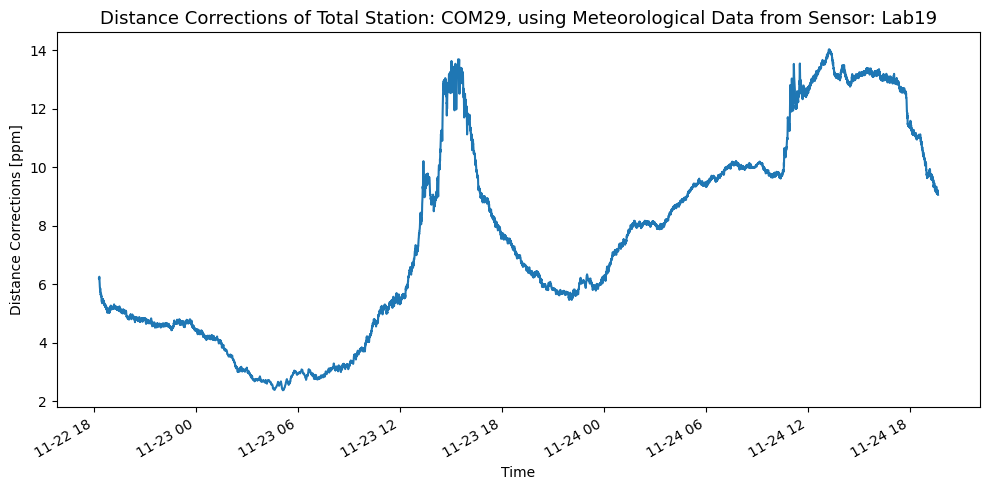

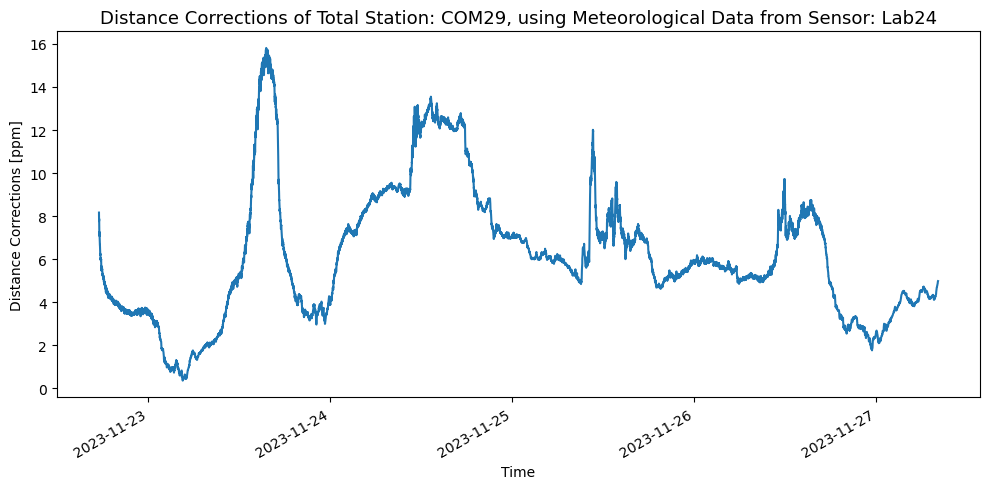

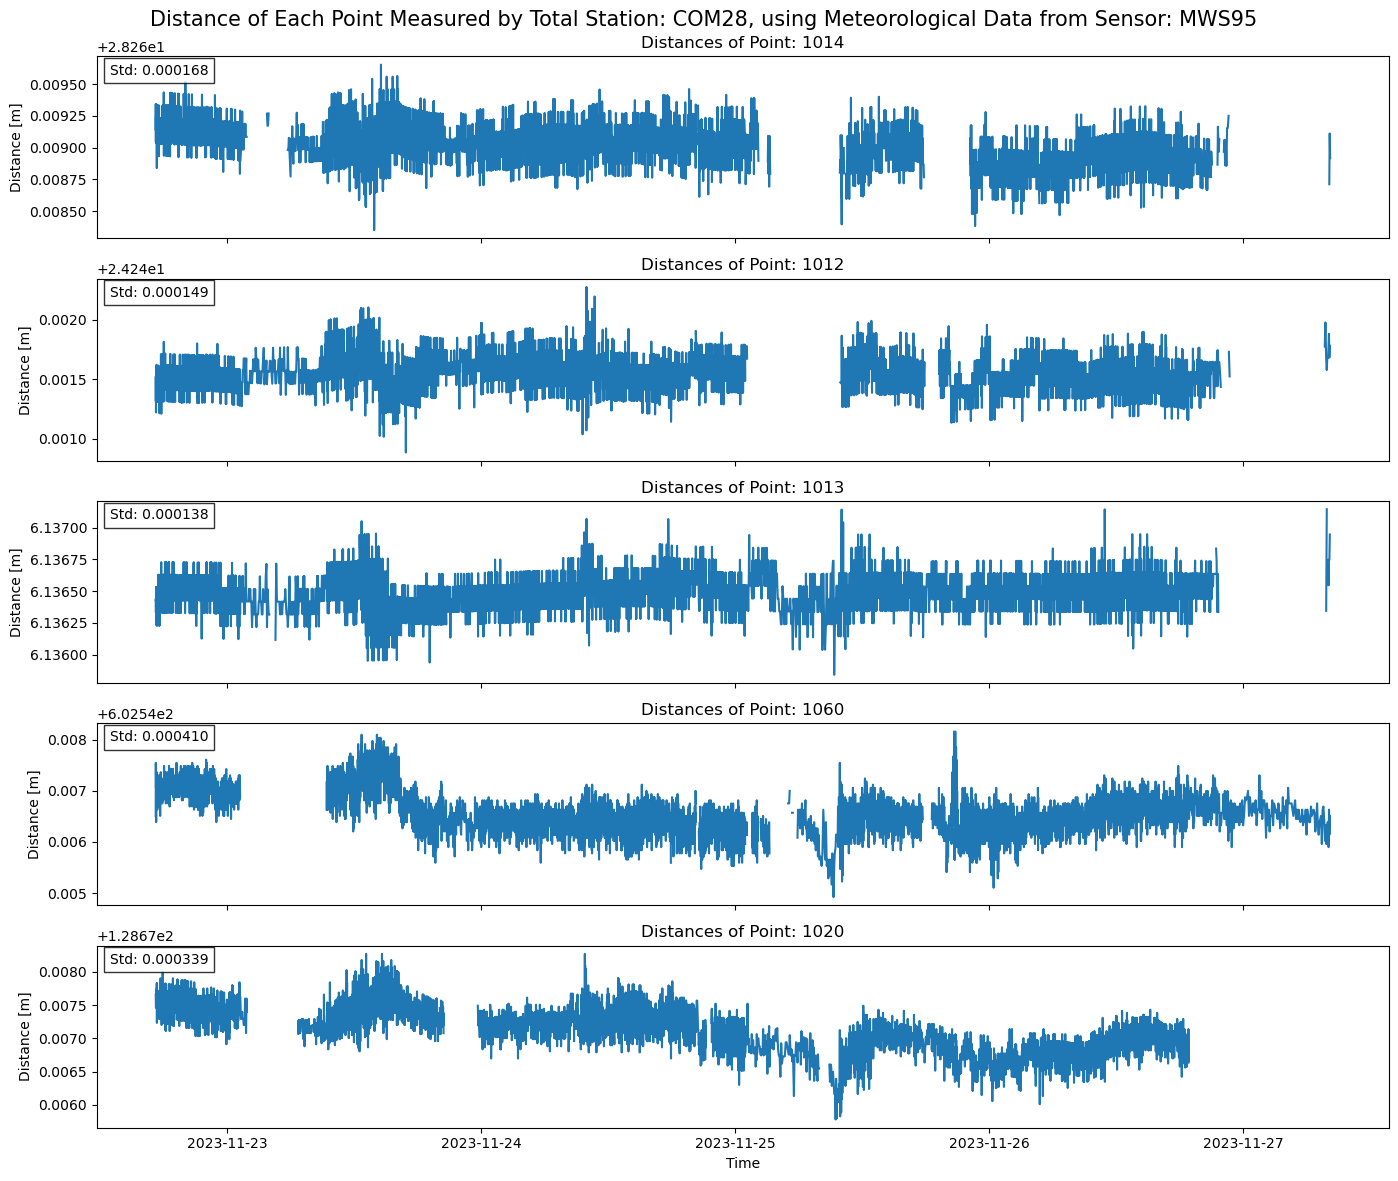

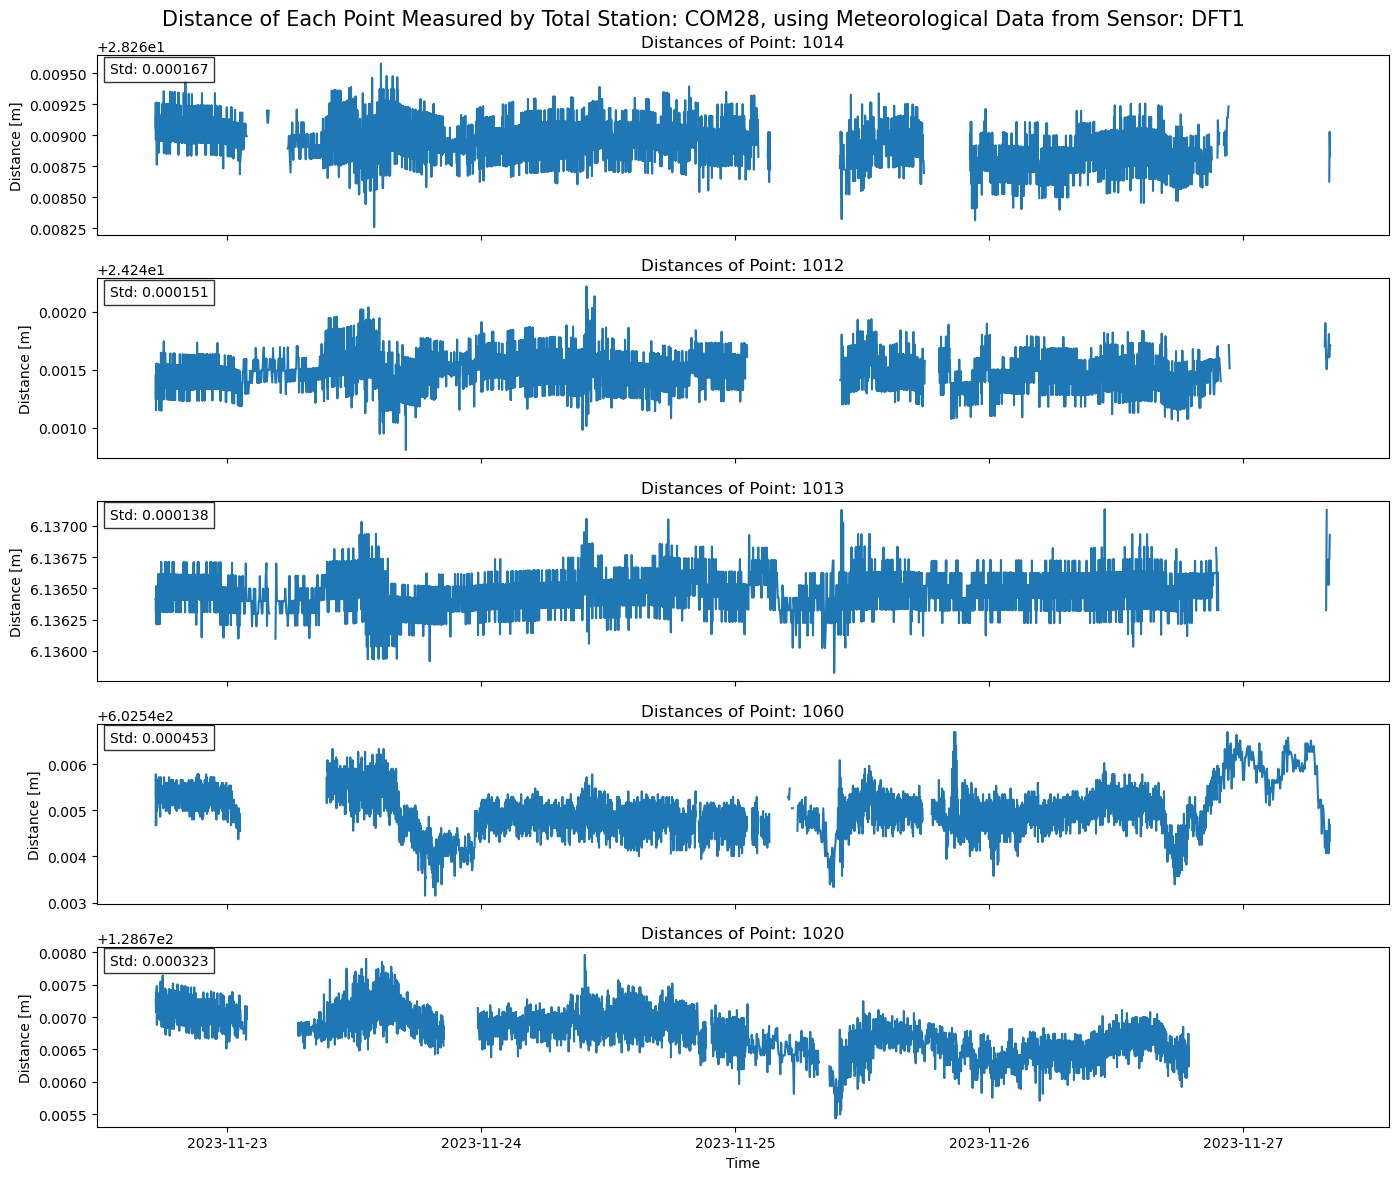

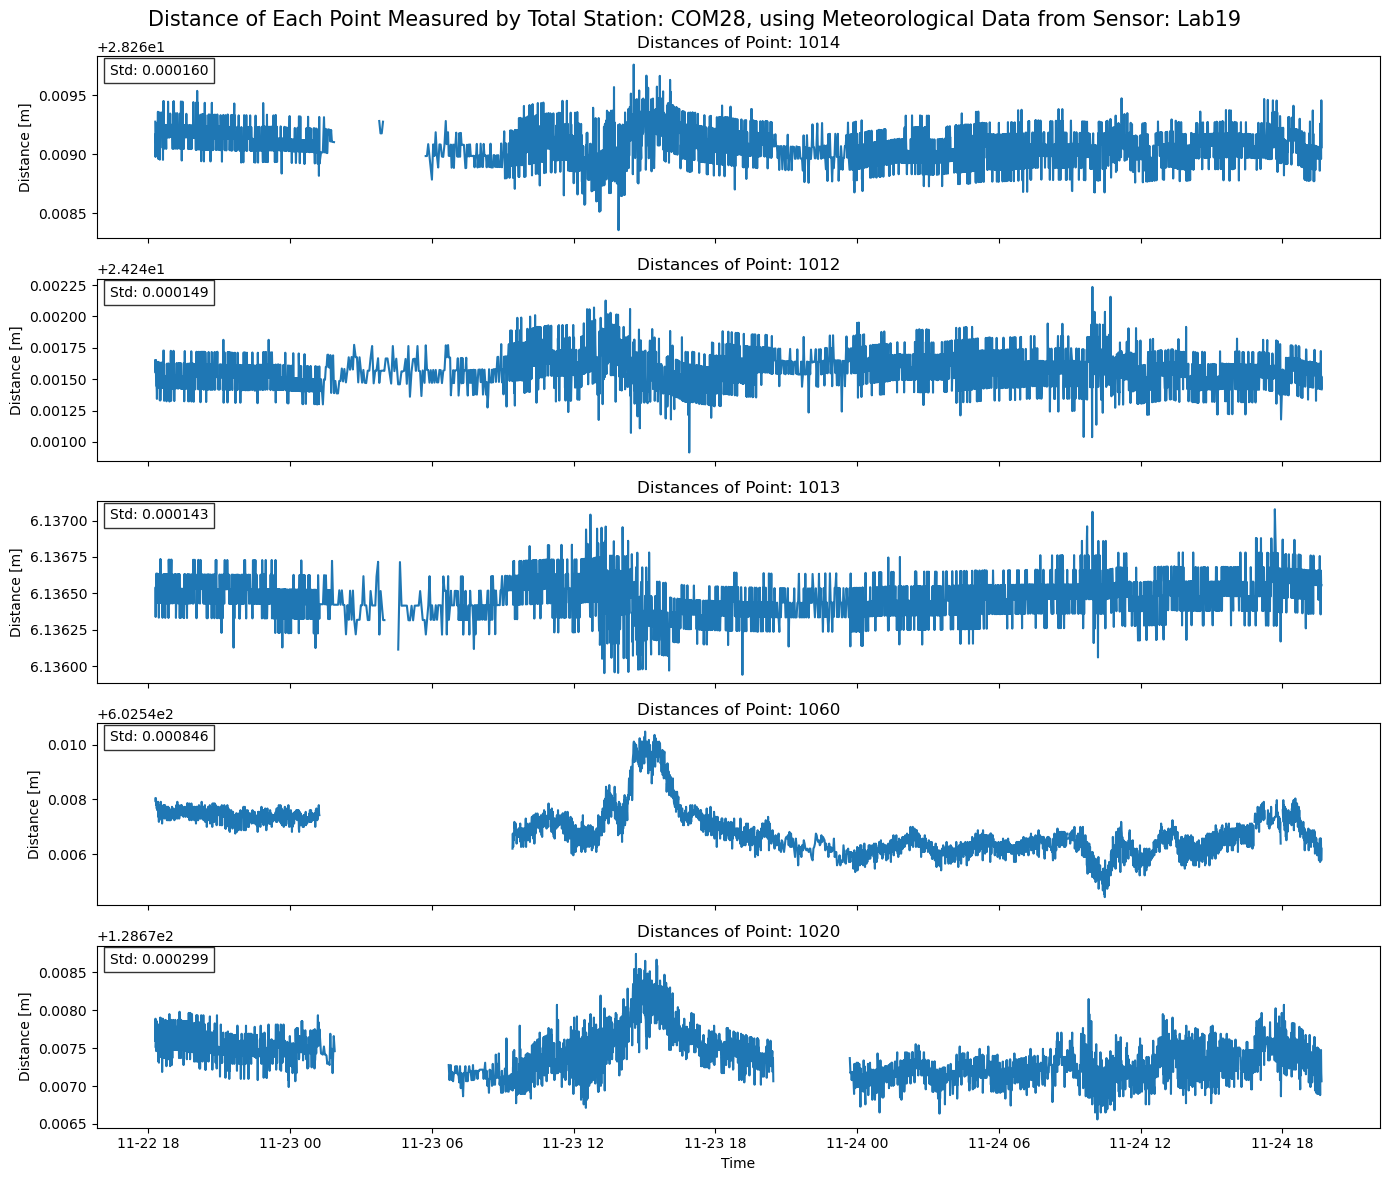

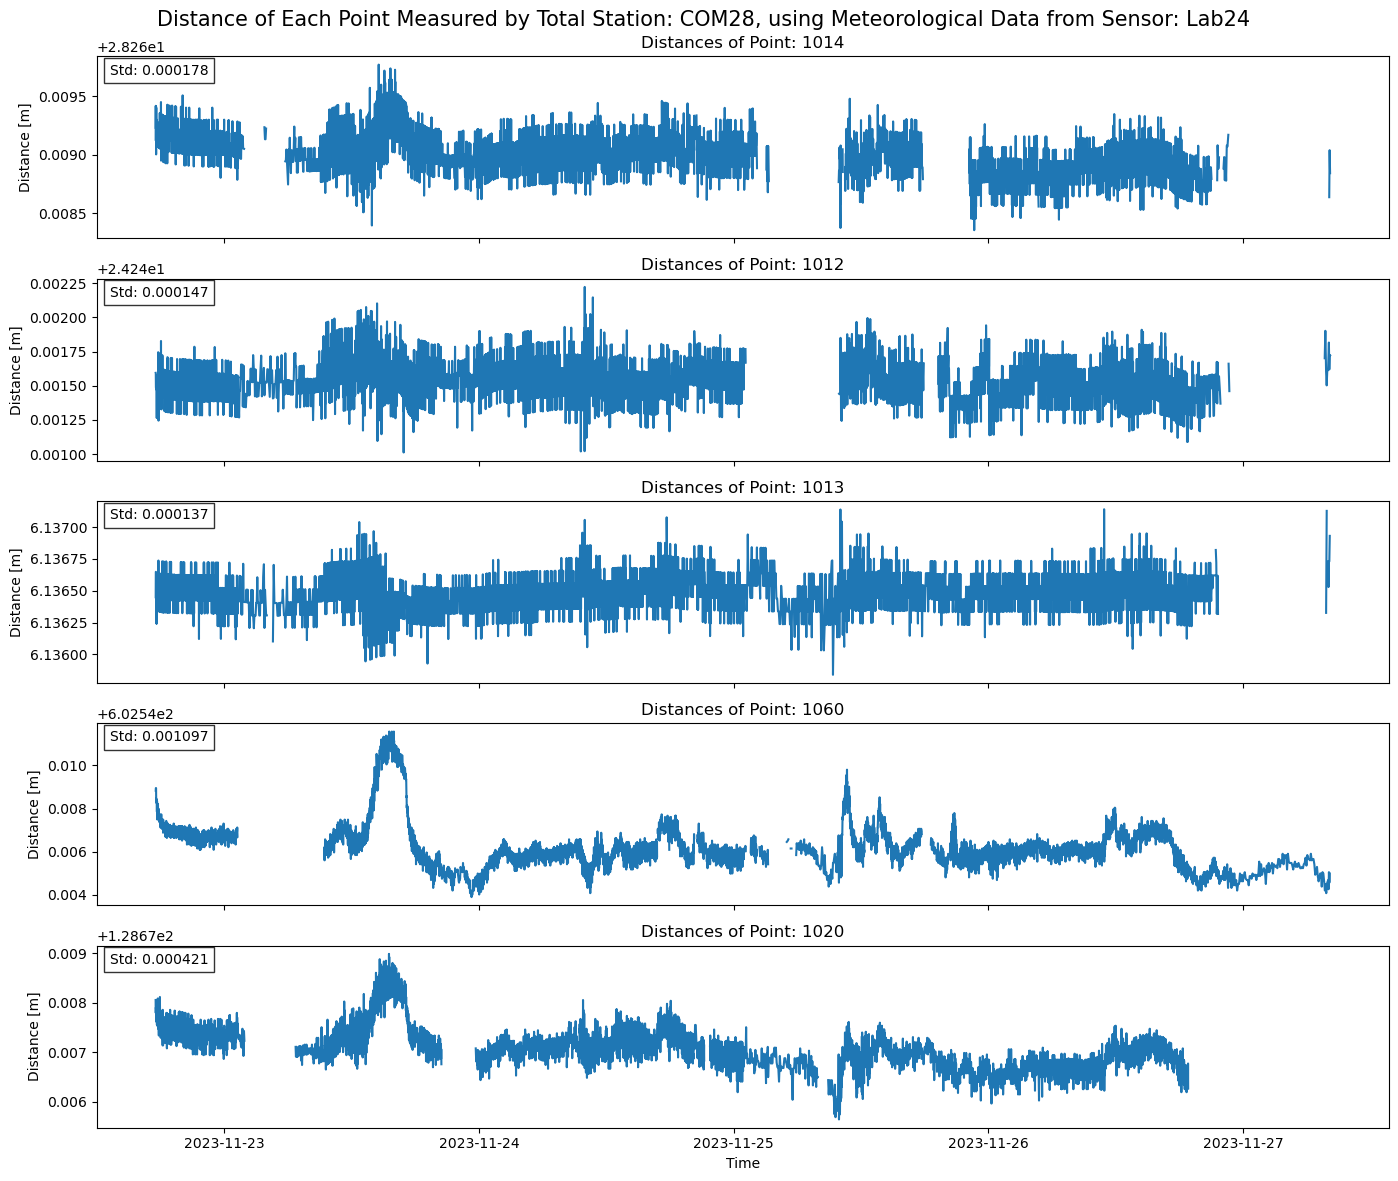

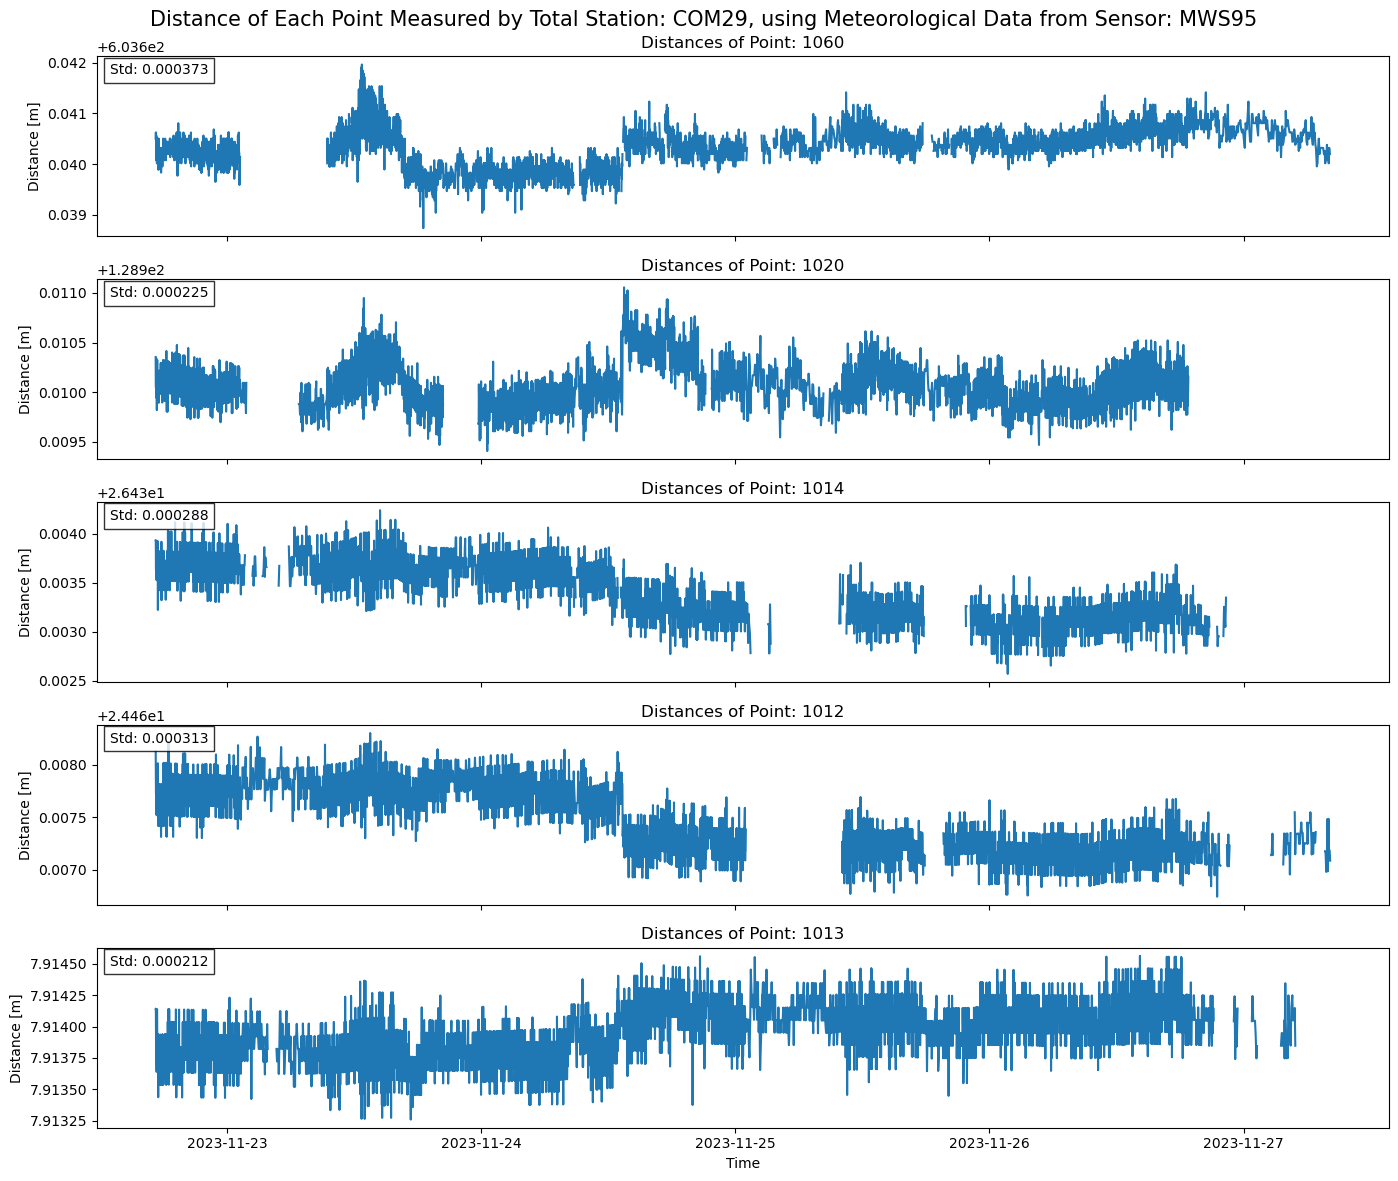

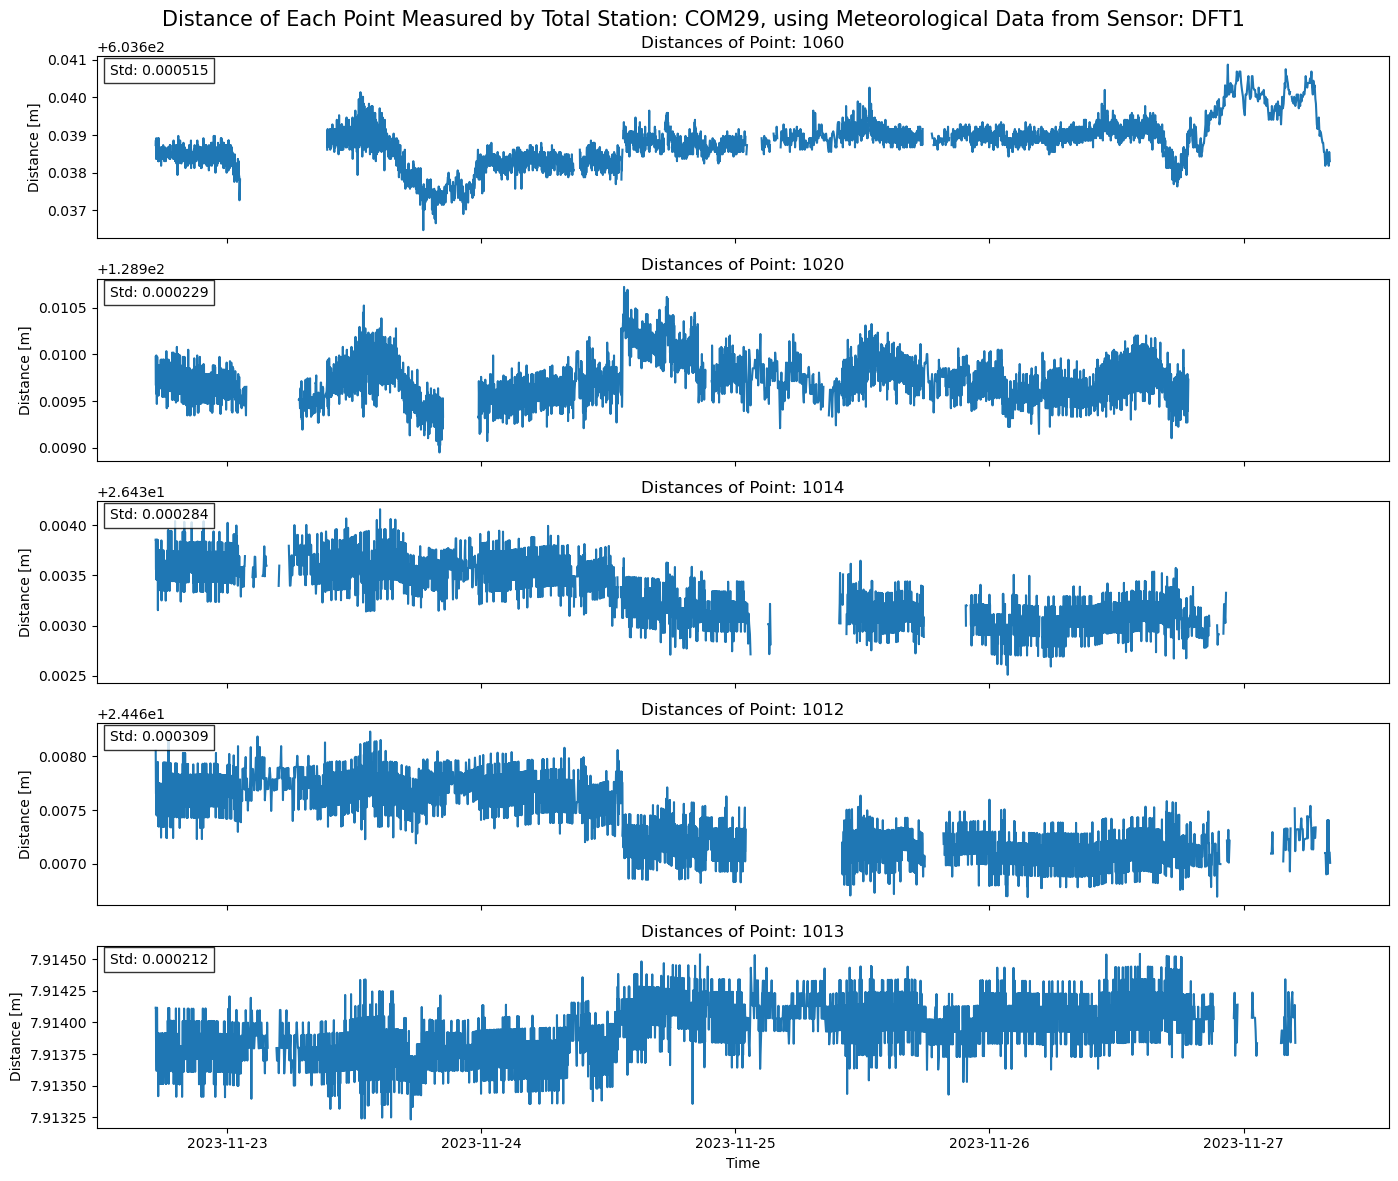

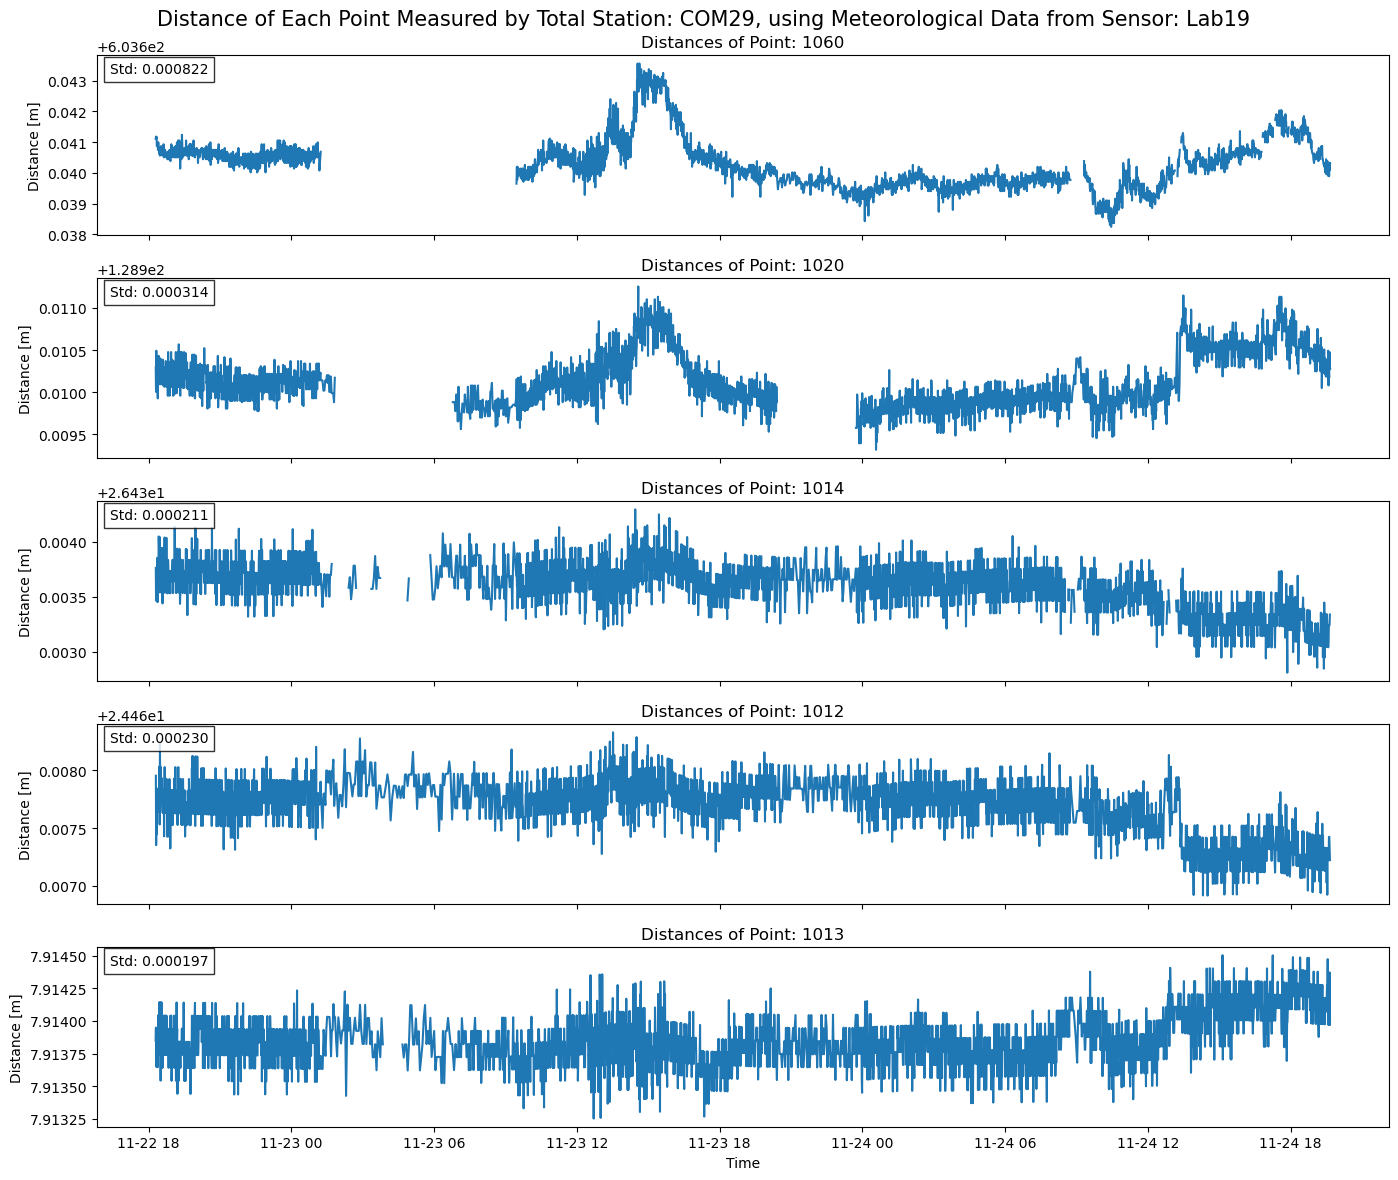

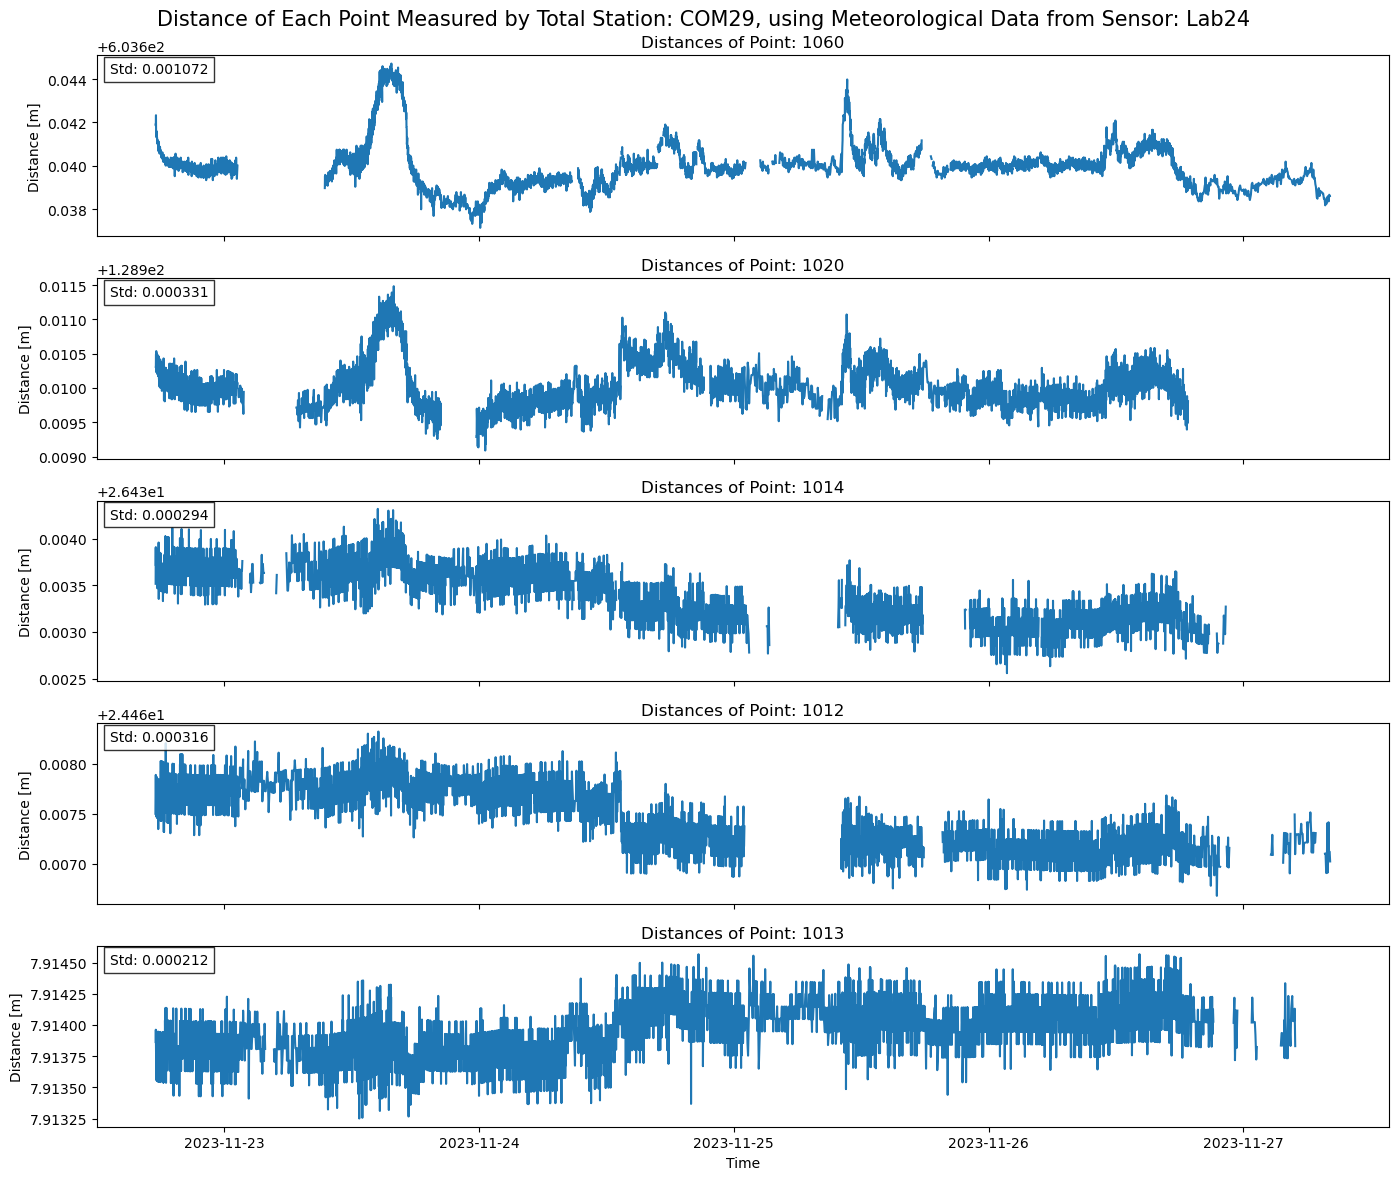

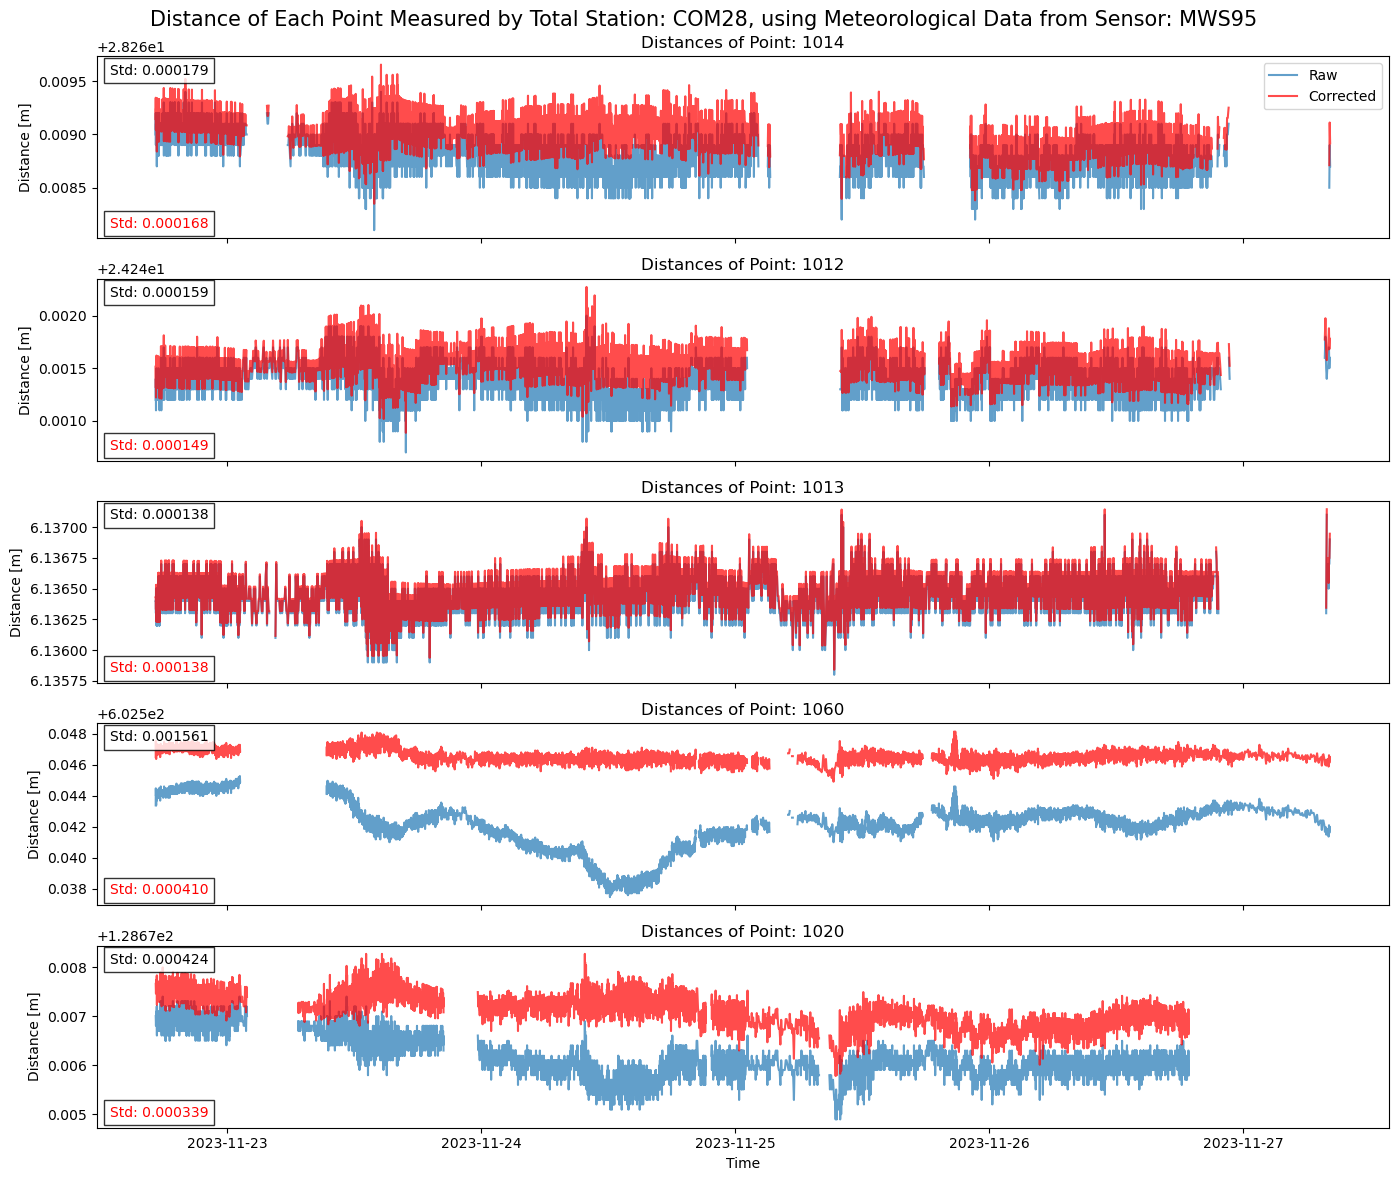

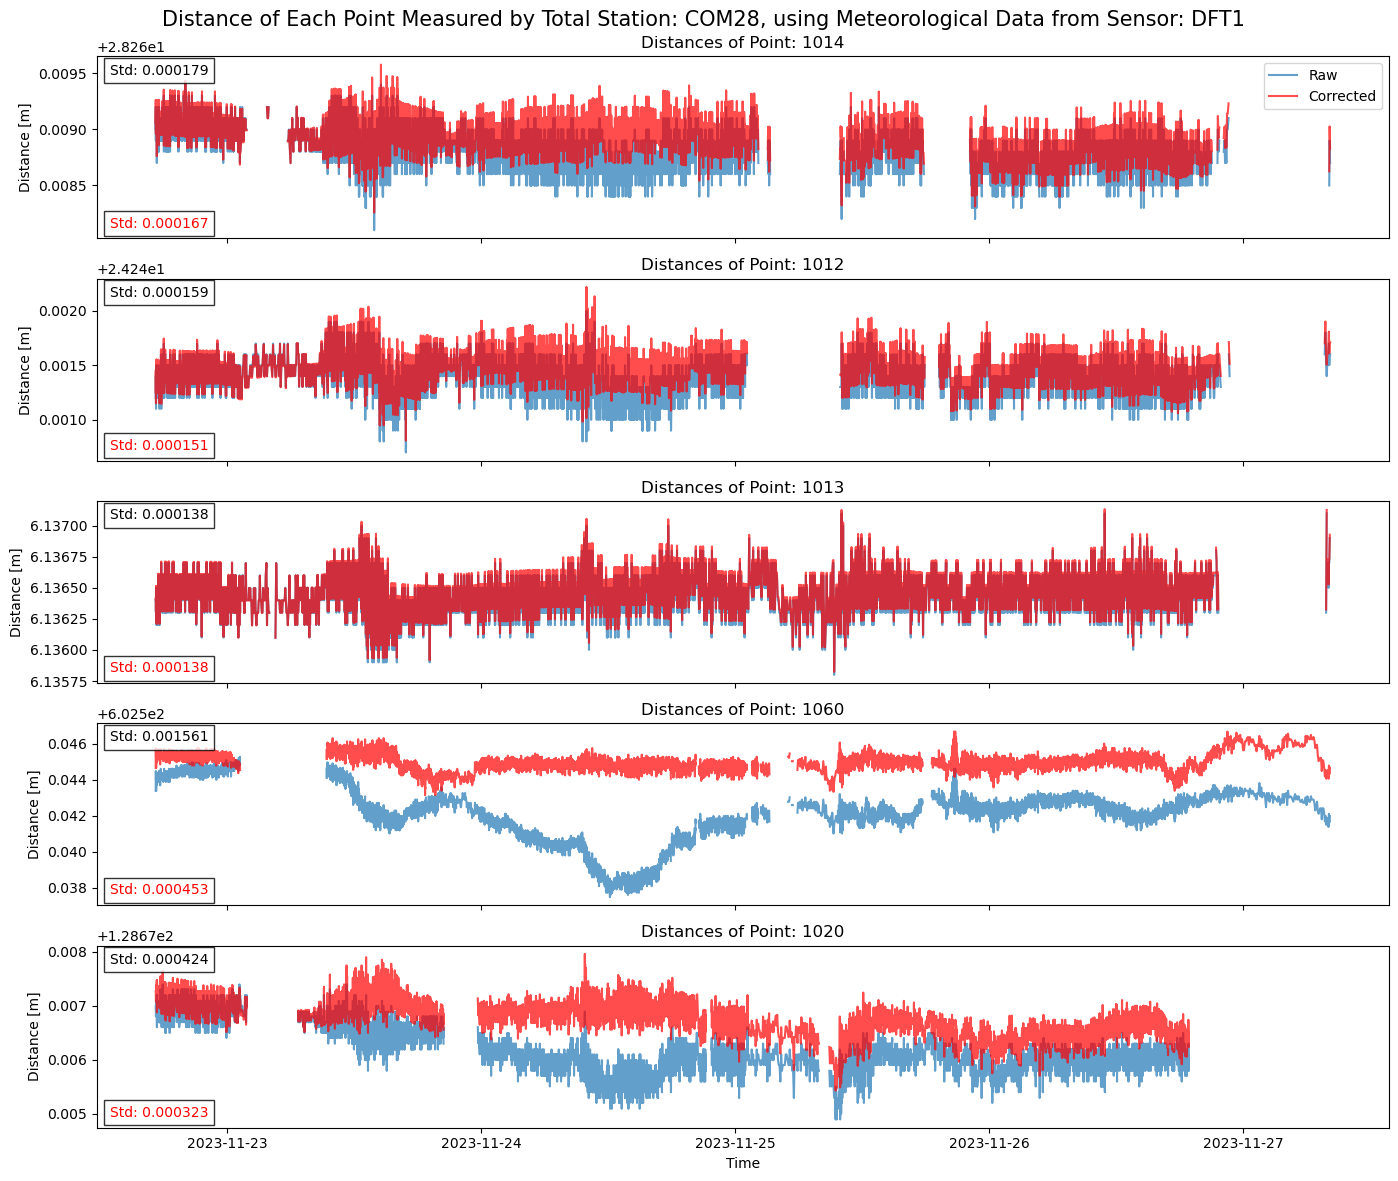

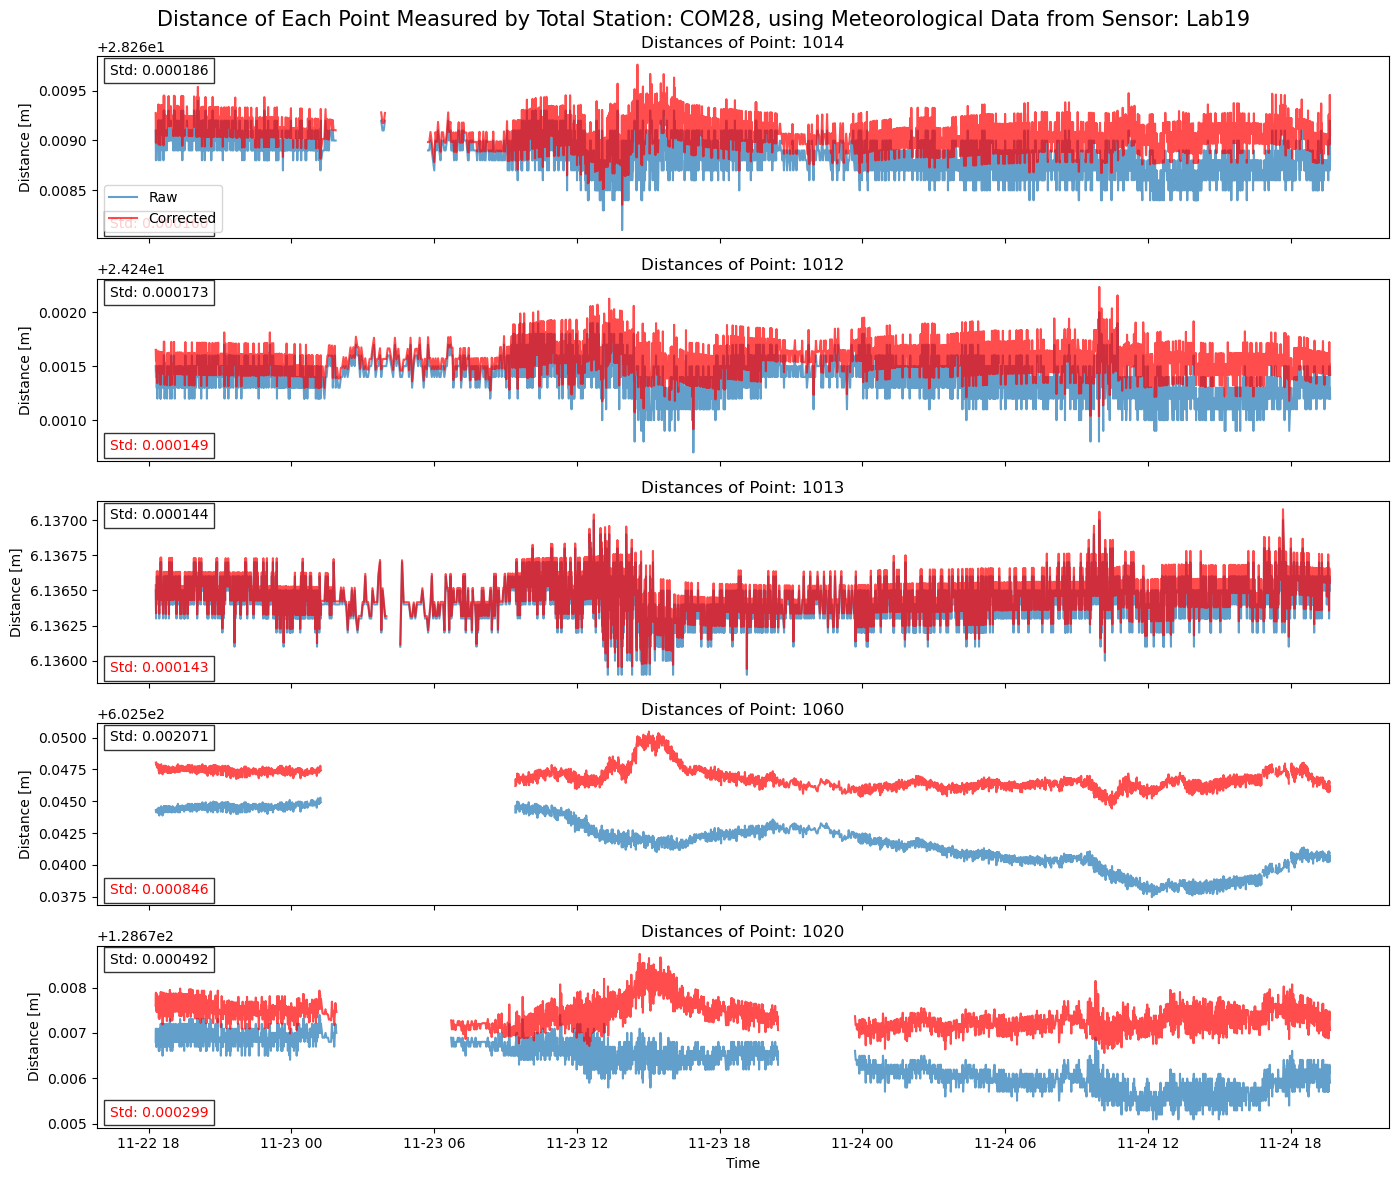

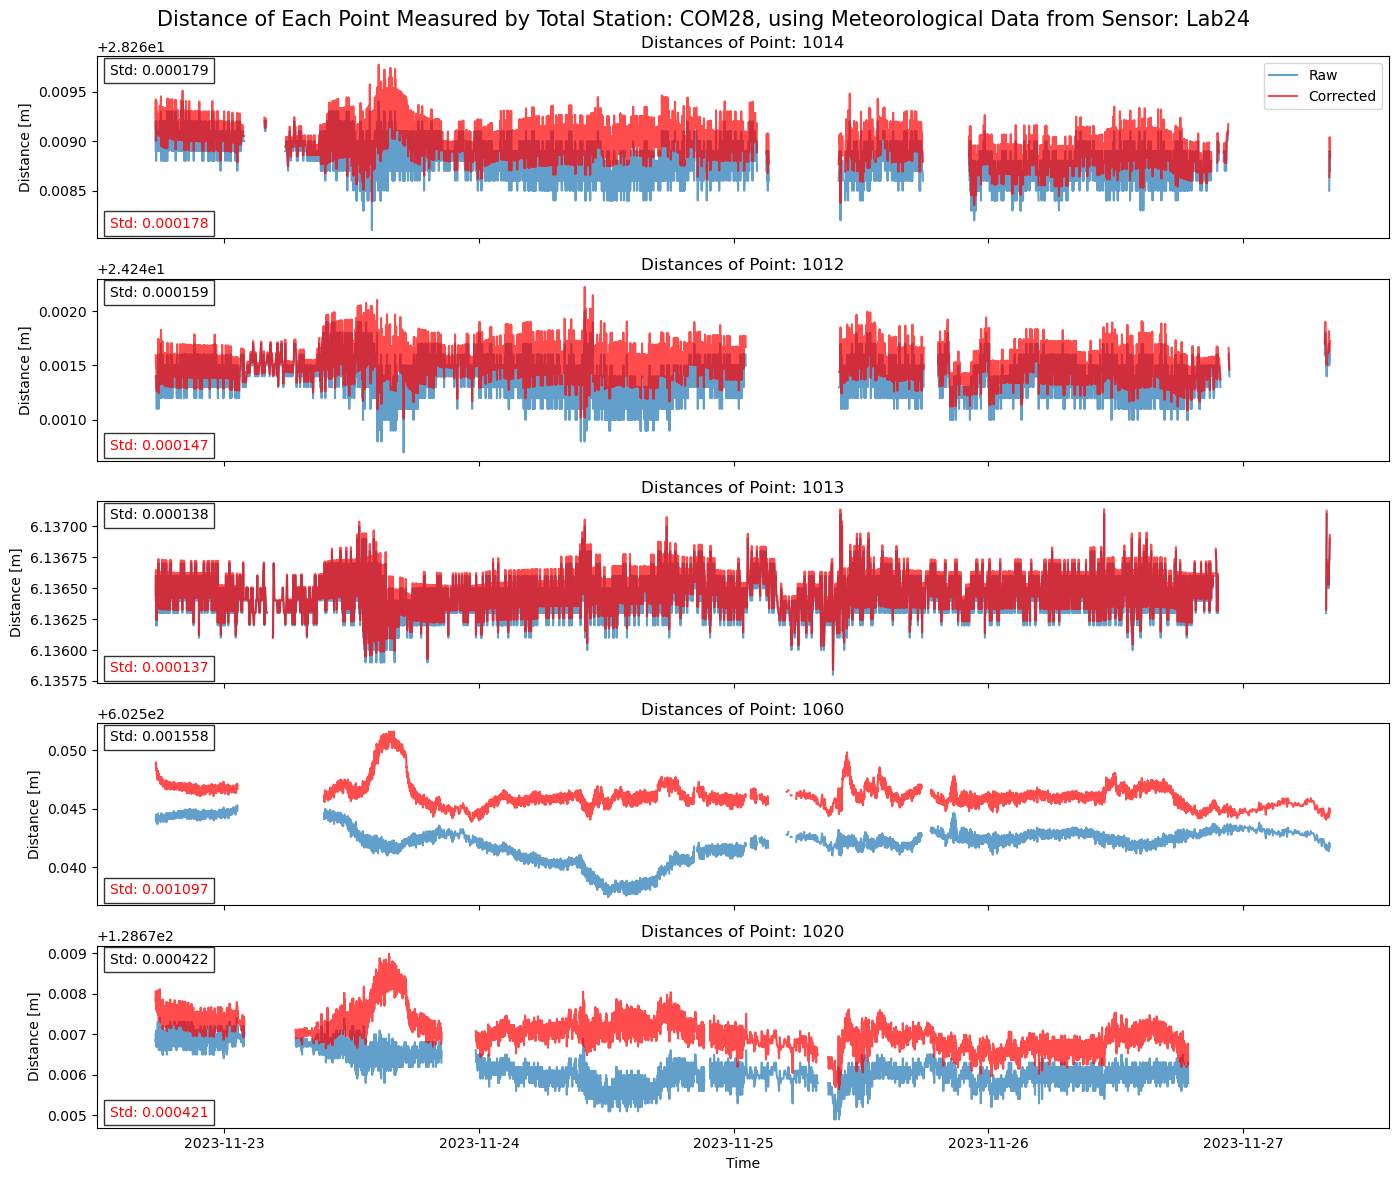

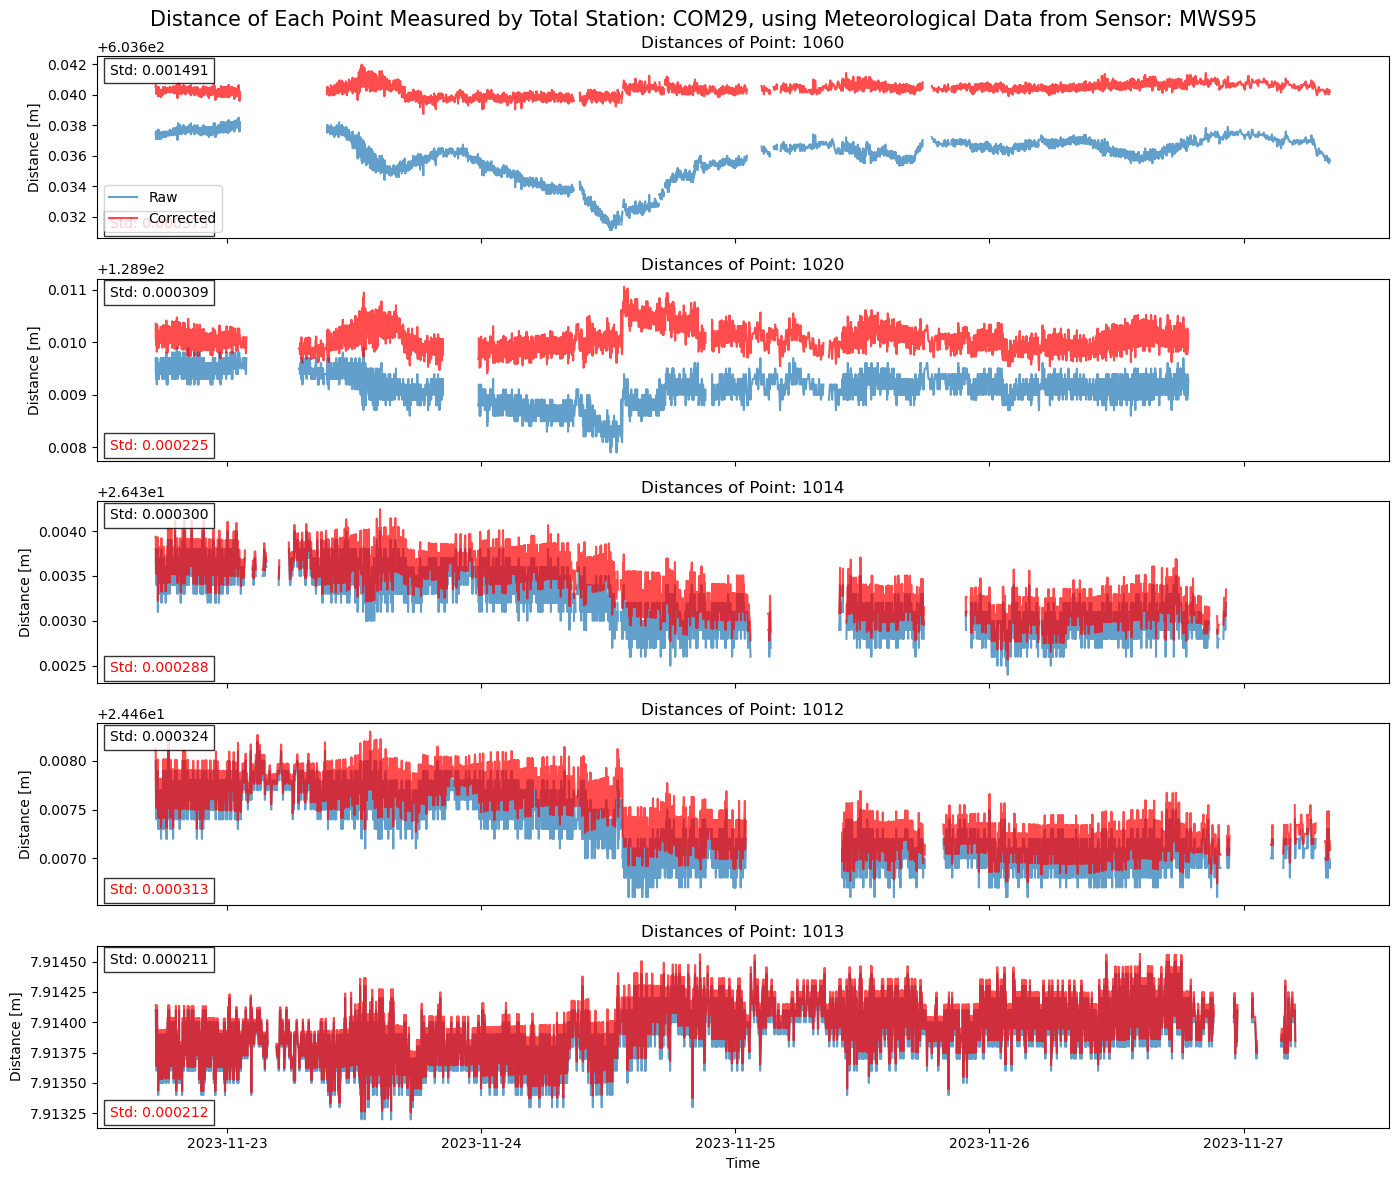

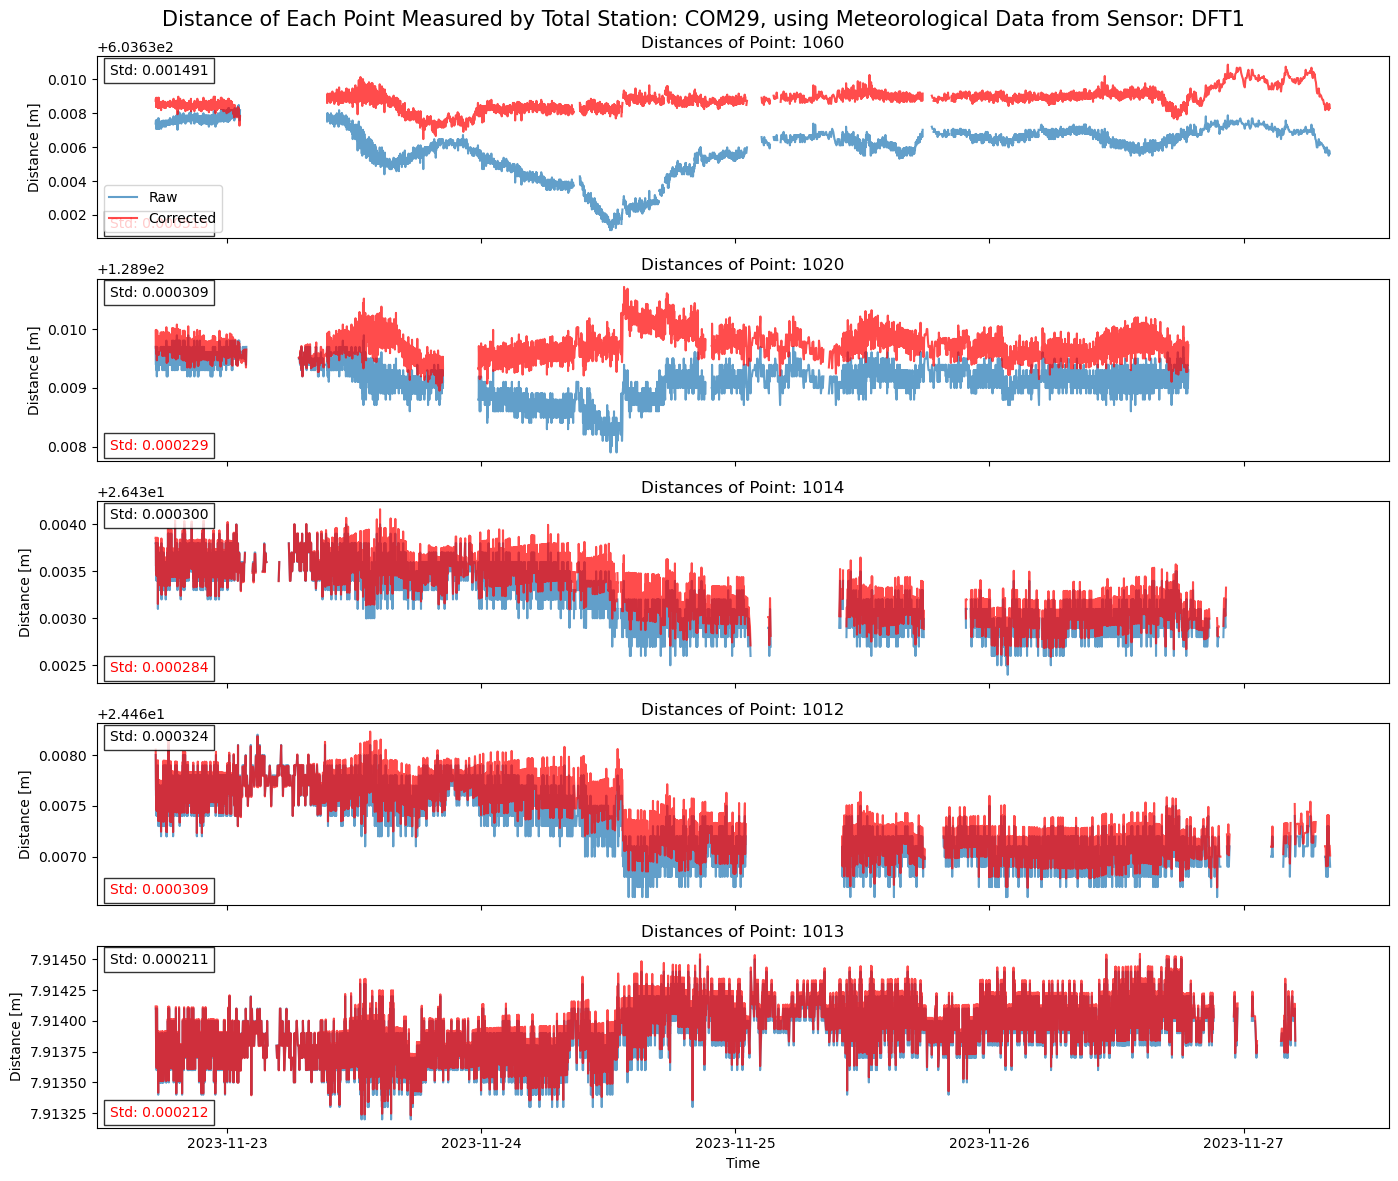

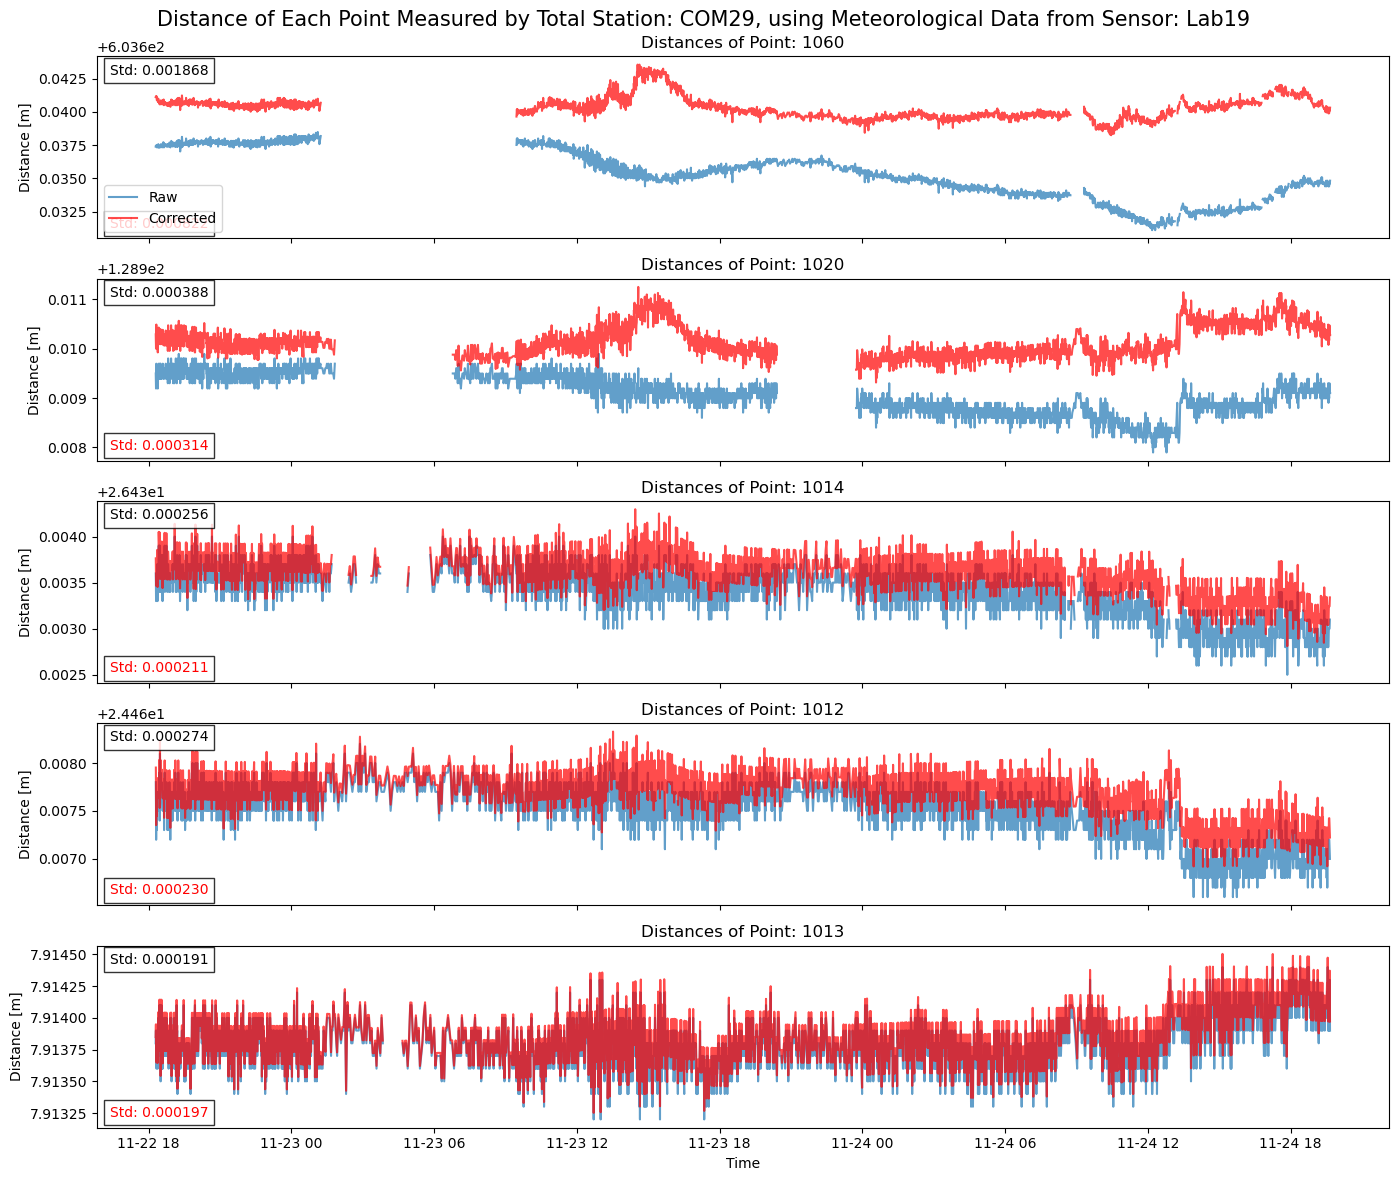

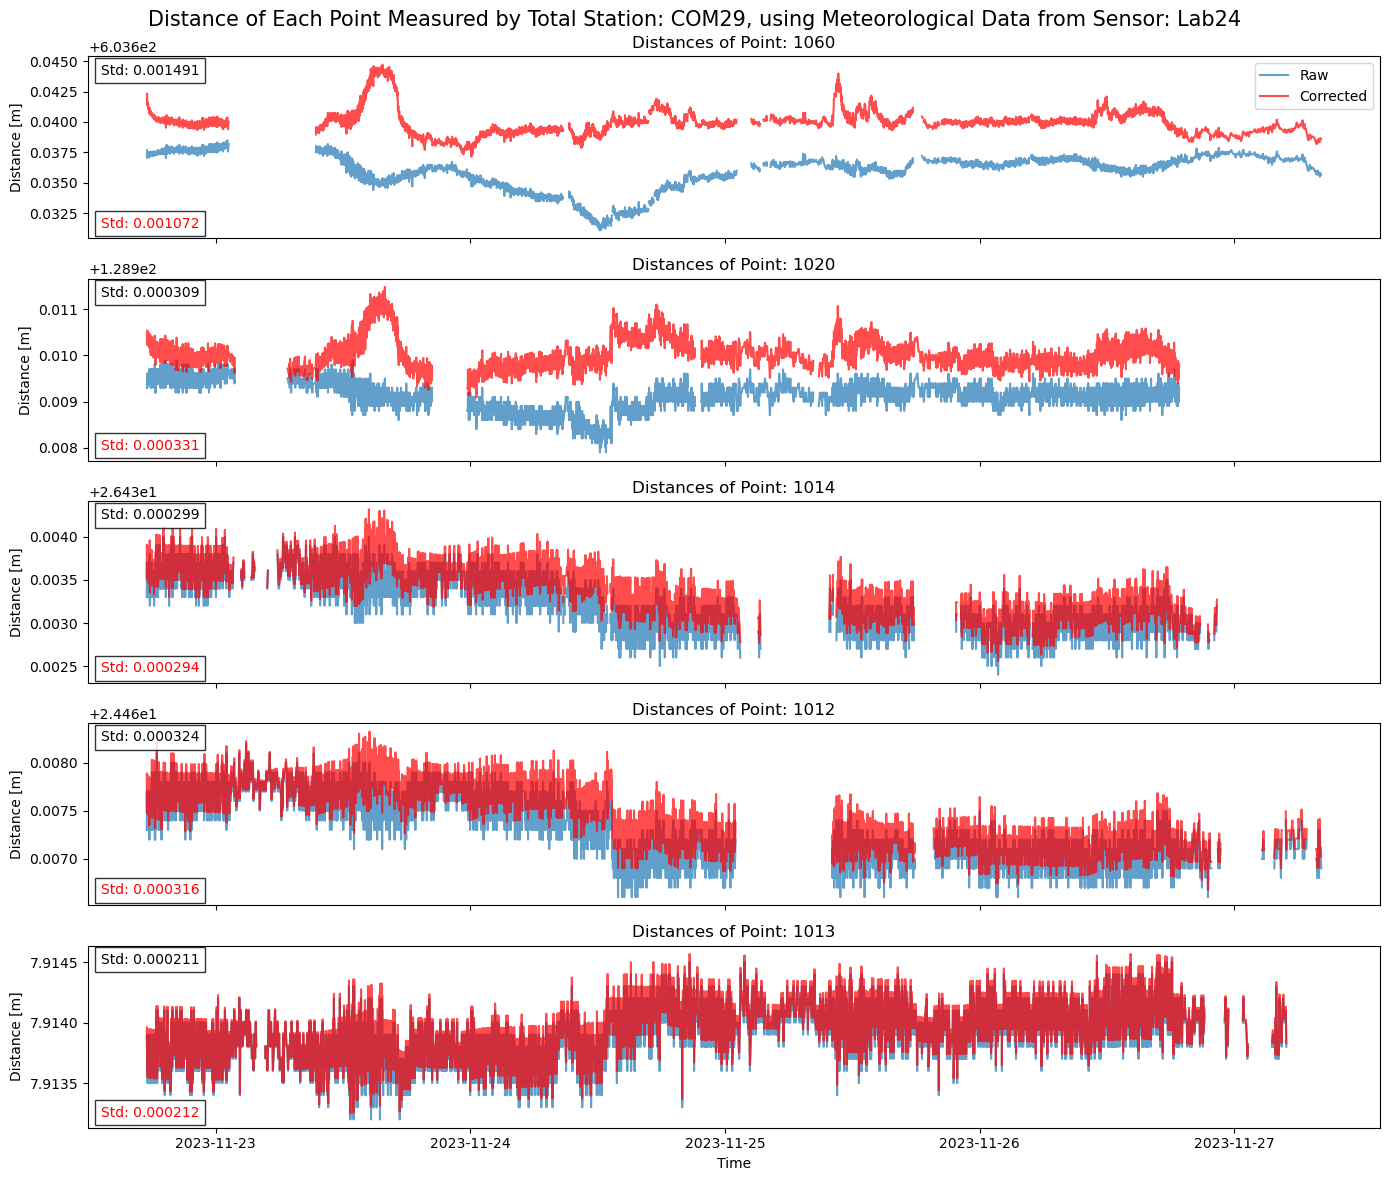

In [21]:
if __name__ == '__main__':
    main()